Проект, данные которого были использованы: https://github.com/paperscape/paperscape-data

Авторы:
* Rob Knegjens, rknegjens@gmail.com
* Damien George, damien.p.george@gmail.com

**Внимание**. Требуется 13 ГБ оперативы для полного выполнения скрипта. В противном случае, может понадобится swap-раздел.

In [1]:
from arxiv import load_arxiv, ArxivTags, get_density_graph
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import networkx as nx
from collections import Counter

lines = '''
Astrophysics (astro-ph)
Condensed Matter (cond-mat)
Computer Science (cs)
Economics (econ)
Electrical Engineering and Systems Science (eess)
General Relativity and Quantum Cosmology (gr-qc)
High Energy Physics - Experiment (hep-ex)
High Energy Physics - Lattice (hep-lat)
High Energy Physics - Phenomenology (hep-ph)
High Energy Physics - Theory (hep-th)
Mathematics (math)
Mathematical Physics (math-ph)
Nonlinear Sciences (nlin)
Nuclear Experiment (nucl-ex)
Nuclear Theory (nucl-th)
Physics (physics)
Quantitative Biology (q-bio)
Quantitative Finance (q-fin)
Quantum Physics (quant-ph)
Statistics (stat)
'''.split('\n')

deprecated = '''
Accelerator Physics (acc-phys, subsumed into physics.acc-ph)
Adaptation, Noise, and Self-Organizing Systems (adap-org, subsumed into nlin.AO)
Algebraic Geometry (alg-geom, subsumed into math.AG)
Atmospheric-Oceanic Sciences (ao-sci, subsumed into physics.ao-ph)
Atomic, Molecular and Optical Physics (atom-ph, subsumed into physics.atom-ph)
Bayesian Analysis (bayes-an, subsumed into physics.data-an)
Chaotic Dynamics (chao-dyn, subsumed into nlin.CD)
Chemical Physics (chem-ph, subsumed into physics.chem-ph)
Computation and Language (cmp-lg, subsumed into cs.CL)
Cellular Automata and Lattice Gases (comp-gas, subsumed into nlin.CG)
Differential Geometry (dg-ga, subsumed into math.DG)
Functional Analysis (funct-an, subsumed into math.FA)
Materials Theory (mtrl-th, subsumed into cond-mat.mtrl-sci)
Pattern Formation and Solitons (patt-sol, subsumed into nlin.PS)
Plasma Physics (plasm-ph, subsumed into physics.plasm-ph)
Quantum Algebra and Topology (q-alg, subsumed into math.QA)
Exactly Solvable and Integrable Systems (solv-int, subsumed into nlin.SI)
Superconductivity (supr-con, subsumed into cond-mat.supr-con)
'''.split('\n')

# Создадим связки: 
# * название -> сокращённое название
# * устаревшее название -> новое название
# * новое -> старое название
# Причины создания таких связок https://arxiv.org/archive/
actuals = {l[:-1].split('(')[1]:l[:-1].split('(')[0] for l in lines if l[:-1].split('(')[0] != ''}
new_actuals = {l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:]:l[:-1].split('(')[0] for l in deprecated if l[:-1].split('(')[0] != ''}
repl_actuals = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[0]  + '(D)' for l in deprecated if l[:-1].split('(')[0] != ''}
new_depr = {l[:-1].split('(')[1][:l[:-1].split('(')[1].find(',')]:l[:-1].split('(')[1][l[:-1].split('(')[1].find(',') + 16:] for l in deprecated if l[:-1].split('(')[0] != ''}

def replace_tags(docs):
    for doc in docs:
        new_tags = set([])
        old_tags = set([])
        for tag in docs[doc][ArxivTags.GeneralTags]:
            if tag in new_depr:
                old_tags.add(tag)
                new_tags.add(new_depr[tag])
        for tag in new_tags:
            docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
        for tag in old_tags:
            docs[doc][ArxivTags.GeneralTags].remove(tag)
            
    for doc in docs:
        new_tags = set([])
        old_tags = set([])
        for tag in docs[doc][ArxivTags.Tags]:
            if tag.split('.')[0] in new_depr:
                old_tags.add(tag)
                new_tags.add(new_depr[tag])
        for tag in new_tags:
            docs[doc][ArxivTags.Tags].add(tag)
        for tag in old_tags:
            docs[doc][ArxivTags.Tags].remove(tag)
            
def remove_noise_tags(docs):
    docs_for_remove = []
    for doc in tqdm_notebook(docs, desc='Удаление документов'):
        if 'eess' in docs[doc][ArxivTags.GeneralTags] or 'econ' in docs[doc][ArxivTags.GeneralTags]:
            docs_for_remove.append(doc)

    for doc in docs_for_remove:
        del docs[doc]

    for doc in tqdm_notebook(docs, desc='Удаление рёбер'):
        valid_edges = []
        for v in docs[doc][ArxivTags.Edges]:
            if v not in docs_for_remove:
                valid_edges.append(v)
        docs[doc][ArxivTags.Edges] = valid_edges

# Раздел 1. Предварительный анализ

Загружаем данные

In [2]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:22<00:00,  1.98s/it]


Построим гистограмму распределения статей

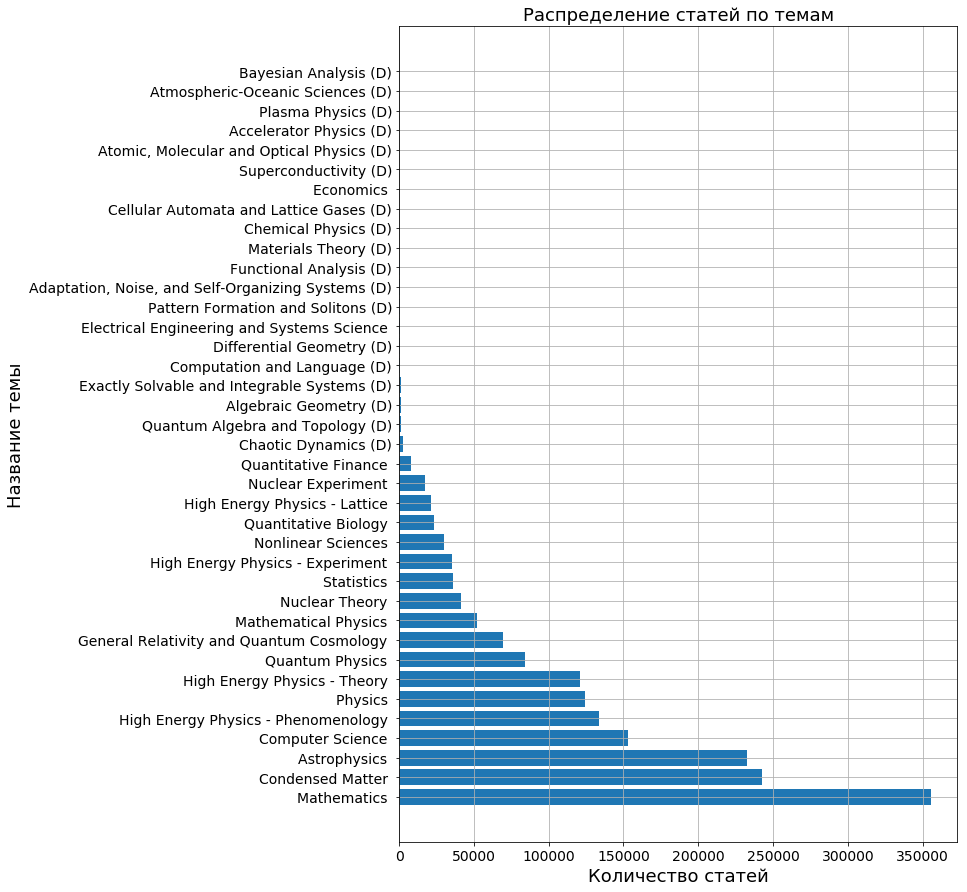

In [97]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
names = [repl_actuals[name] if name in repl_actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.ylabel('Название темы', fontsize=18)
plt.xlabel('Количество статей', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)

del count_themes
del items
del names
del pos
del h

Как видим, существует большое количество типов вершин (тегов или тем), которых крайне мало в обучающей выборке. Как оказалось, этому есть объяснение. Большинство из них являются устаревишми, а две из таких малочисленных категорий оказались новыми. Подробнее об этом можно узнать [тут](https://arxiv.org/archive/). На графике (D) -- deprecated

Теперь сделаем замену: старые группы на новые.

In [98]:
replace_tags(docs)

Ещё раз построим уже модифицированную гистограмму:

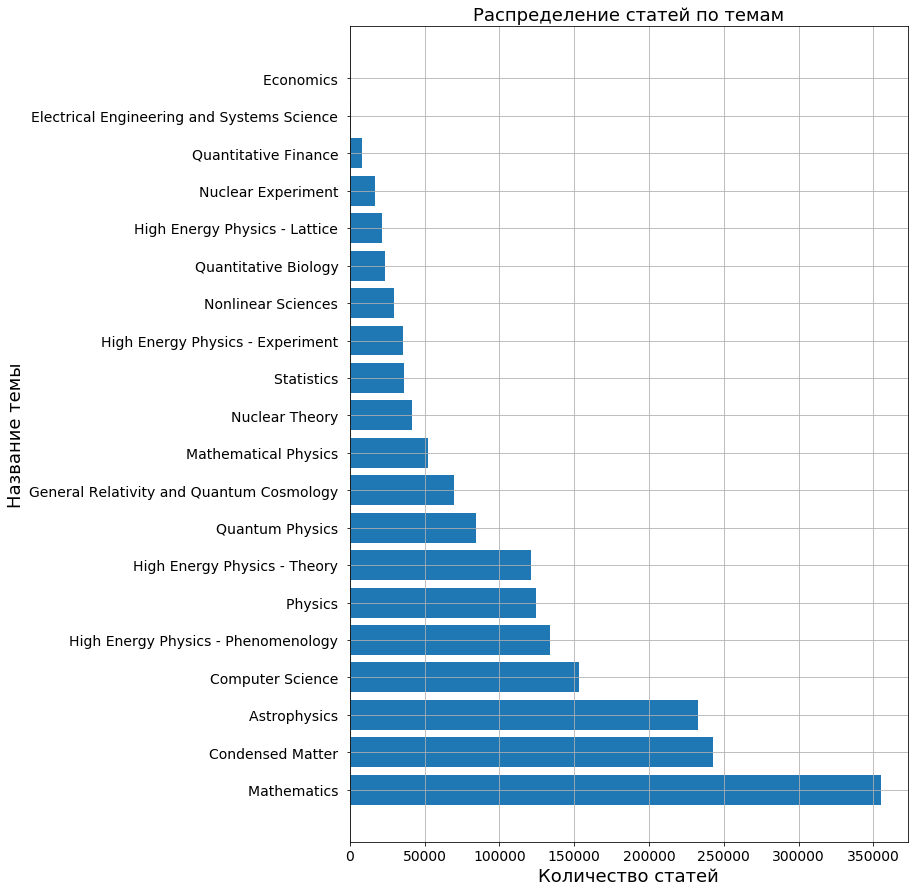

In [99]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.ylabel('Название темы', fontsize=18)
plt.xlabel('Количество статей', fontsize=18)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True)

del count_themes
del items
del names
del pos
del h

Как мы говорили, вы выборке есть новые теги (Данные у нас есть до января 2018 года), а два тега: *Economics* и *Electrical Engineering and Systems Science* появились в сентябре 2017 года. Давайте исключим их, чтобы не портить общую картину.

In [ ]:
remove_noise_tags(docs)

Построим гистограмму без них

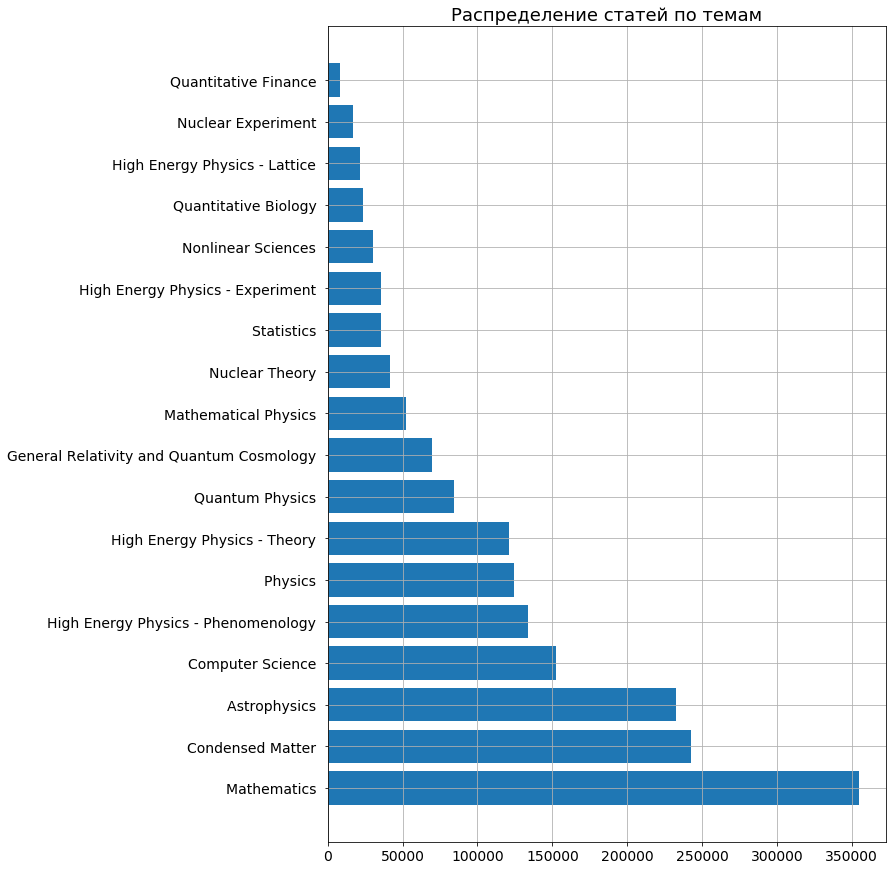

In [10]:
count_themes = Counter()
for doc in docs:
    for tag in docs[doc][ArxivTags.GeneralTags]:
        count_themes[tag] += 1

items = sorted(list(count_themes.items()), key=lambda el: el[1])[::-1]
h = [x[1] for x in items]
names = [x[0] for x in items]
names = [actuals[name] if name in actuals else name for name in names]
pos = list(range(len(h)))
plt.figure(figsize=(10, 15))
plt.title('Распределение статей по темам', fontsize=18)
plt.barh(pos, h)
plt.yticks(pos, names, fontsize=14)
plt.xticks(fontsize=14)
plt.grid(True);

del count_themes
del items
del names
del pos
del h

### Характеристики графа

Давайте теперь займёмся графом. Построим его

In [56]:
del docs

In [3]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:21<00:00,  1.84s/it]


In [4]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

Давайте выделим компоненты связности и посмотрим на их размеры. Прим этом, как легко догадаться, в графе есть гигантская компонента, которую мы исключим. Она включает в себя $76\%$ вершин

In [60]:
cc = list(nx.connected_components(G))

In [61]:
print('Процент вершин в гигантской компоненте связности:', 1 - len(sorted([len(i) for i in cc])[::-1]) / len(docs))

Процент вершин в гигантской компоненте связности: 0.7611042505472944


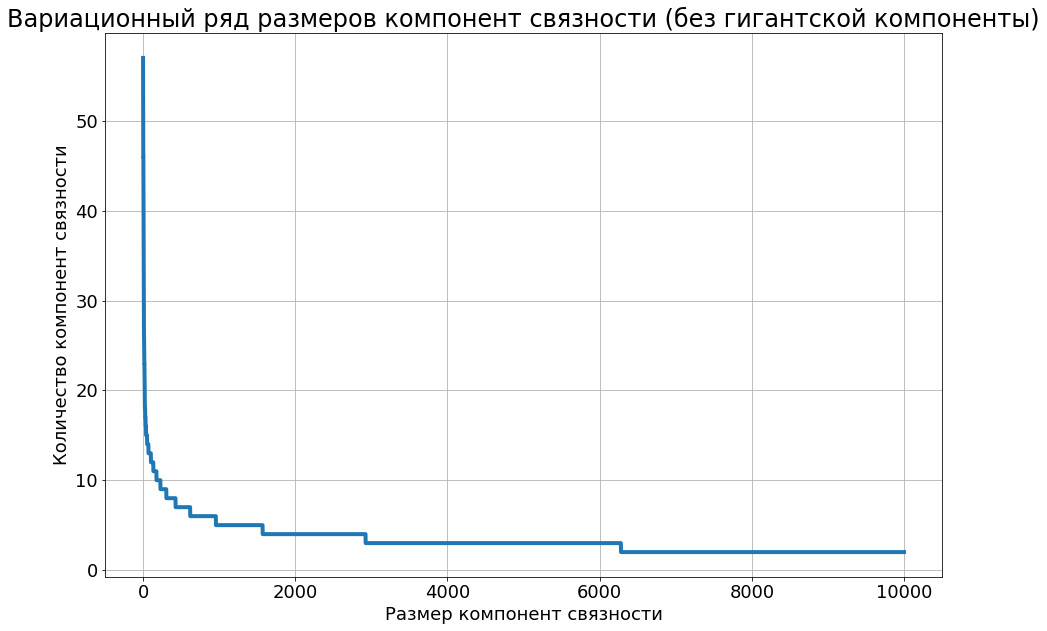

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i) for i in cc])[::-1][1:10000], linewidth=4)
plt.title('Вариационный ряд размеров компонент связности (без гигантской компоненты)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Размер компонент связности', fontsize=18)
plt.ylabel('Количество компонент связности', fontsize=18)
plt.grid(True);

Как видим, существуют достаточно большие компоненты связности (до 50 статей), которые не связаны с гиганской компонентой. Исследуем этот вопрос. Есть гипотеза, которая связана связанна с тем, что есть кластеры образуются вокруг определённых авторов, которые занимаются той или иной темой


### Кластеры размером более 4 статей

Взглянем на несколько из кластеров и на авторов, которые писали статьи:

In [63]:
clusters = sorted([i for i in cc], key=lambda el: len(el))[::-1]

In [78]:
def plot_clusters(cluster_num, max_authors=20, show_authors=True):
    authors = []
    for name in clusters[cluster_num]:
        authors += docs[name][ArxivTags.Authors]

    items = sorted(Counter(authors).items(), key=lambda el: el[1])[::-1][:max_authors]
    h = [item[1] for item in items]
    names = [item[0] for item in items]
    plt.plot(h, 'r-', linewidth=3)
    plt.yticks(fontsize=18)
    if show_authors:
        plt.xticks(list(range(len(names))), names, rotation=60, fontsize=18)
        plt.xlabel('Имя автора', fontsize=18)
    plt.ylabel('Количество упоминаний', fontsize=18)
    plt.title('Число статей, в которых человек является соавтором в отдельном кластере', fontsize=18)
    plt.grid(True)

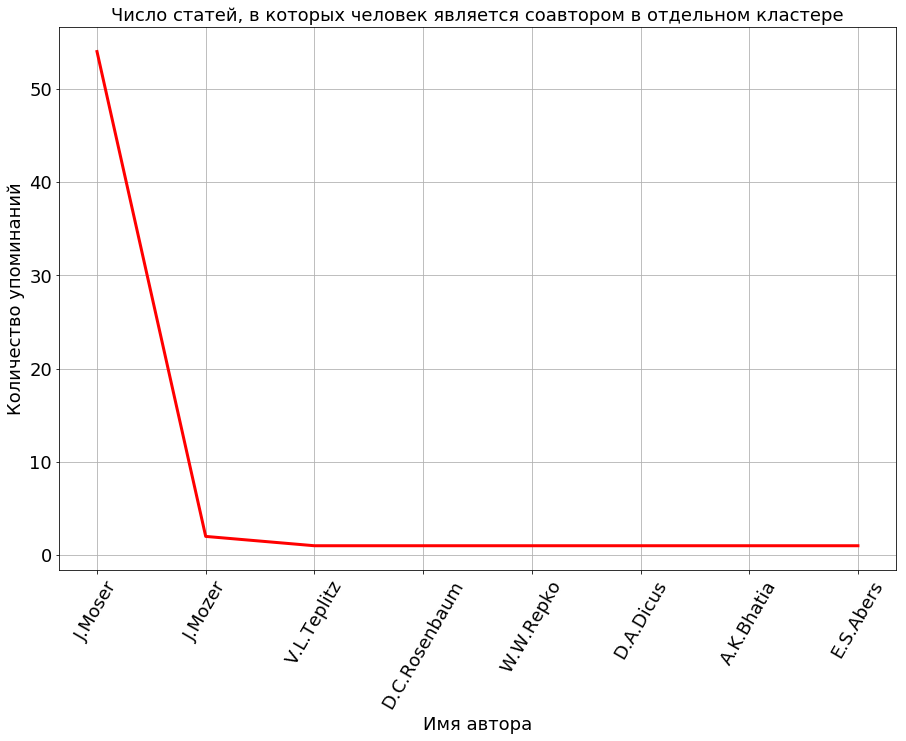

In [79]:
plt.figure(figsize=(15,10))
plot_clusters(1)

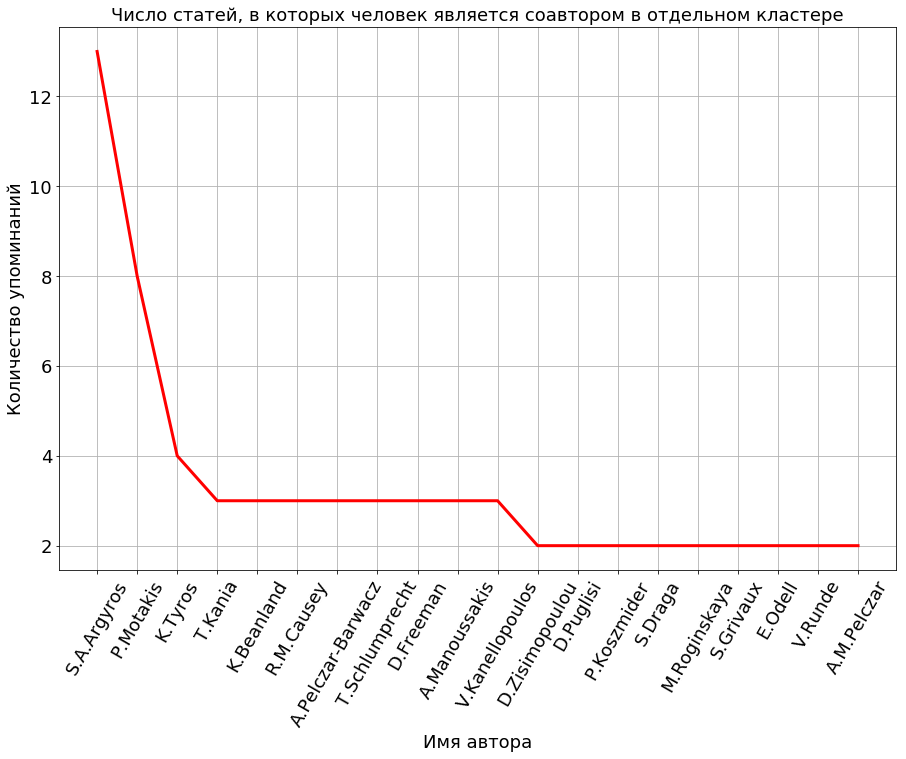

In [80]:
plt.figure(figsize=(15,10))
plot_clusters(2)

Теперь давайте выведем больше графиков

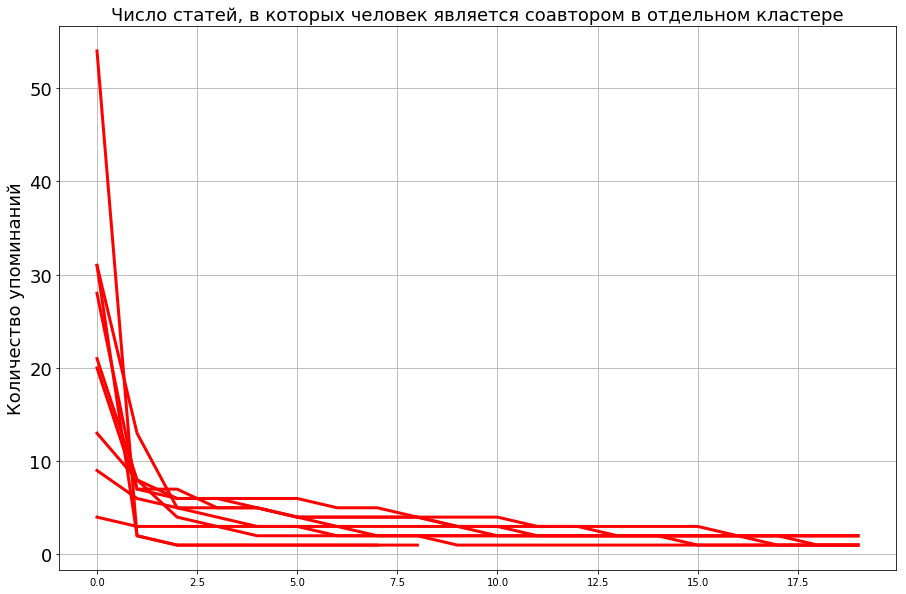

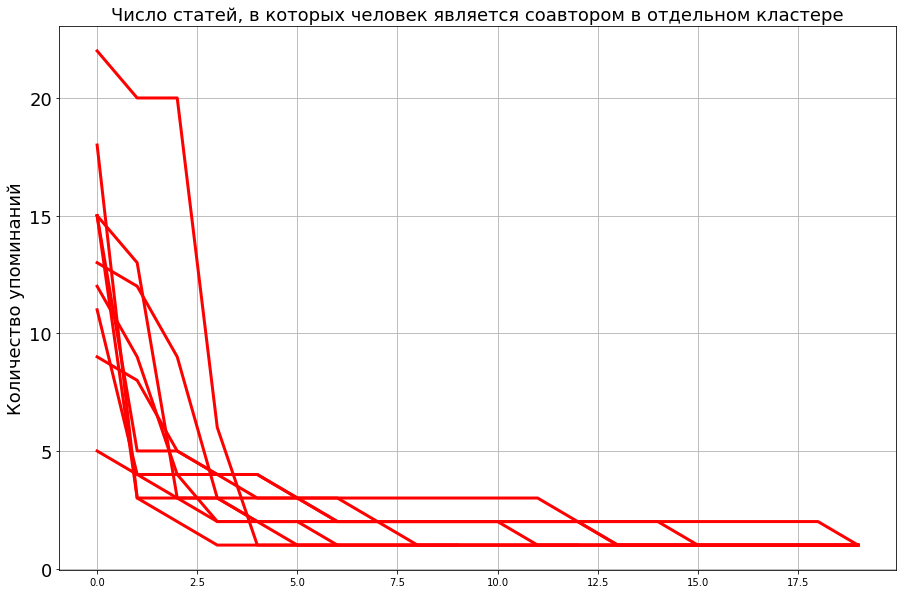

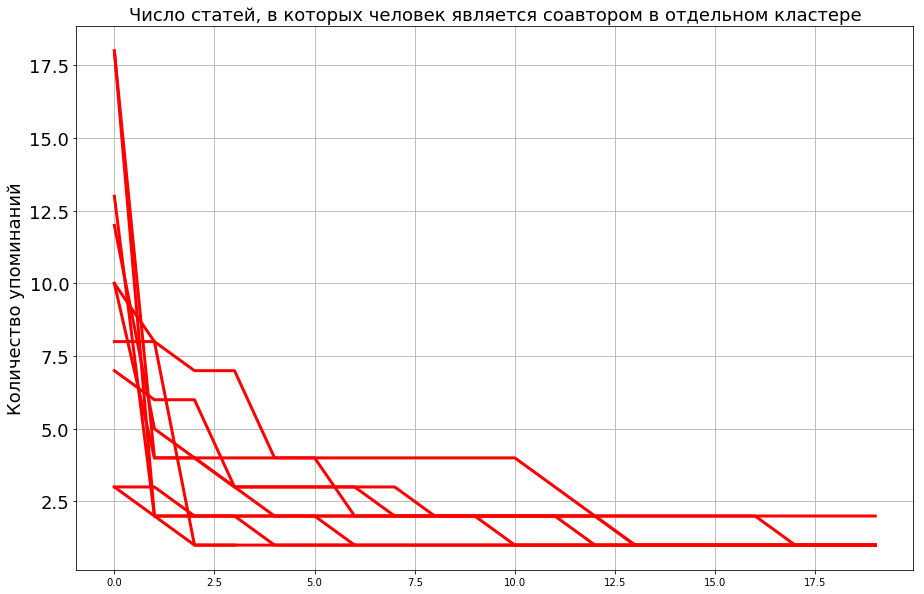

In [81]:
plt.figure(figsize=(15,10))
for i in range(1, 10):
    plot_clusters(i, show_authors=False)
    
plt.figure(figsize=(15,10))
for i in range(10, 20):
    plot_clusters(i, show_authors=False)
    
plt.figure(figsize=(15,10))
for i in range(20, 30):
    plot_clusters(i, show_authors=False)

Ага, интересно... мы видим, что есть существенная доля авторов, которые во многих статьях являются соавторами. Будем называть человека, который чаще других (в рамках конкретного кластера) пишет статьи, **идеологом**. Процент статей, в которых идеолог являлся автором (соавтором), будем называть **идеологическими**. Давайте посмотрим на гистограмму идеологических статей в мелких (не гигантской компоненте) кластерах.

In [203]:
def plot_ideological_hist(t, bins):
    ideological = []
    count_papers = []
    for cluster in clusters[1:]:
        authors = []
        count = 0
        if len(cluster) < t:
            continue
        for name in cluster:
            authors += docs[name][ArxivTags.Authors]
            count += 1
        ideological.append([item[1] for item in Counter(authors).items()])
        count_papers.append(count)

    ideologs = []
    for n, p in zip(count_papers, ideological):
        ideologs.append(max(p) / n)

    plt.figure(figsize=(15, 10))
    plt.hist(ideologs, bins=bins)
    plt.ylabel('Количество кластеров', fontsize=18)
    plt.xlabel('Доля идеологических статей в кластере размера не менее %d' % t, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True)

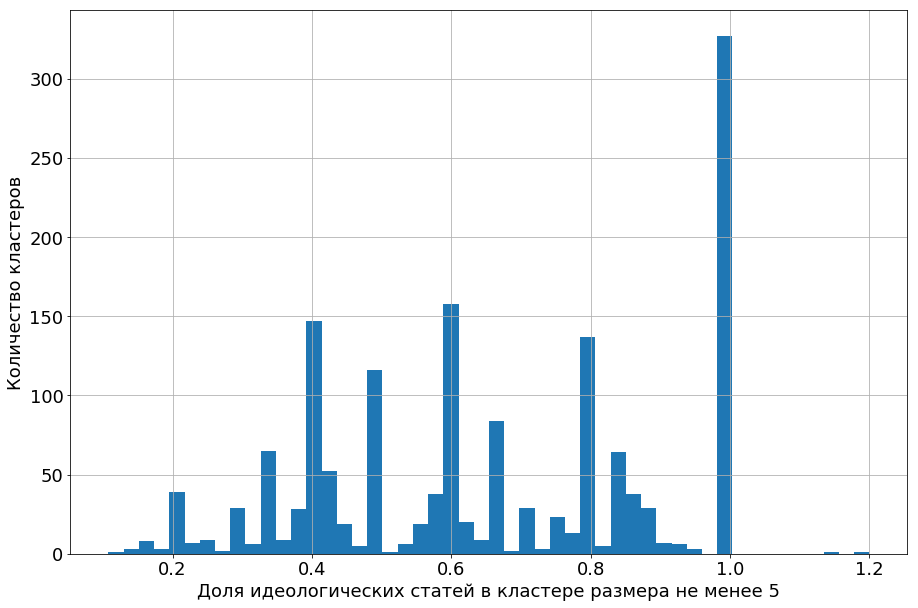

In [204]:
plot_ideological_hist(5, 50)

Первое, что бросается в глаза -- это пик в точке 1. Он легко может быть объяснён. Существует много авторов, которые участвовали в написании каждой статьи кластера.

Ещё один аспект, который также кажется странным -- это то, что есть значения более 1. Это легко объяснить. В ряде кластеров, есть авторы, у которых одинаковые инициалы и фамилии. Скорее всего это родственники. Вероятнее всего, китайцы.

Исследуем явные пики в нескольких точках, помимо 1. Они явно выделяются. Для этого, прежде всего построим несколько гистограмм помельче.

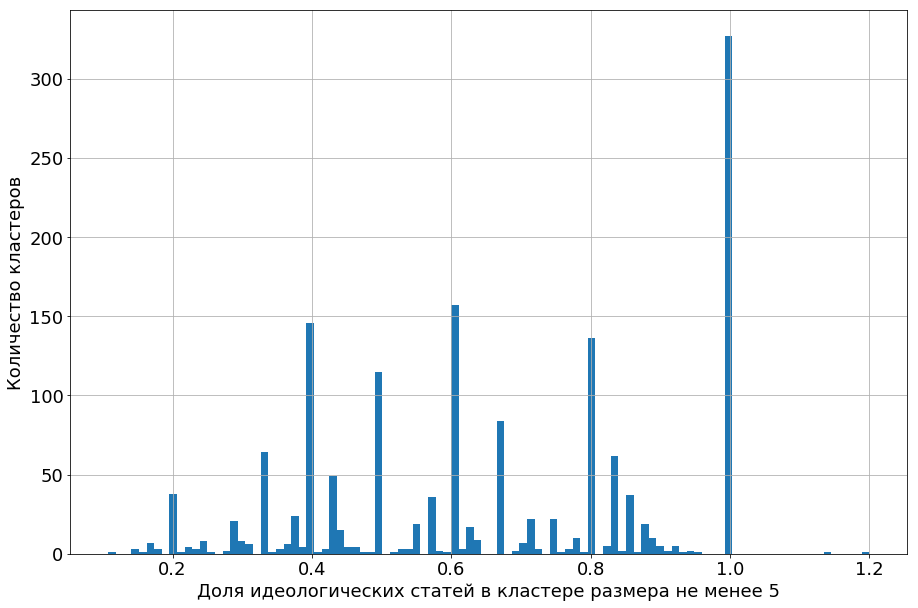

In [239]:
plot_ideological_hist(5, 100)

Как легко заметить, выделяются явные пики в точках 0.2, 0.4, 0.5, 0.6, 0.8. Для того, чтобы ответить на вопрос о причинах такого поведения гистограммы, давайте представим 0.2, 0.4, 0.6, 0.8, 0.5 в виде дробей: $\dfrac{1}{5}, \dfrac{2}{5}, \dfrac{3}{5}, \dfrac{4}{5}, \dfrac{1}{2}$. В результате, пики в дробях с 5 в знаменателе, легко объяснимы. Они означают, что $k \cdot n$ из $k  \cdot  m$ статей писал идеолог, где $n$, $m$ -- части дроби вида $\dfrac{n}{m}$. Отметим указанные точки, соответствующие указанным дробям на графике, чтобы продемонстрировать закономерность.

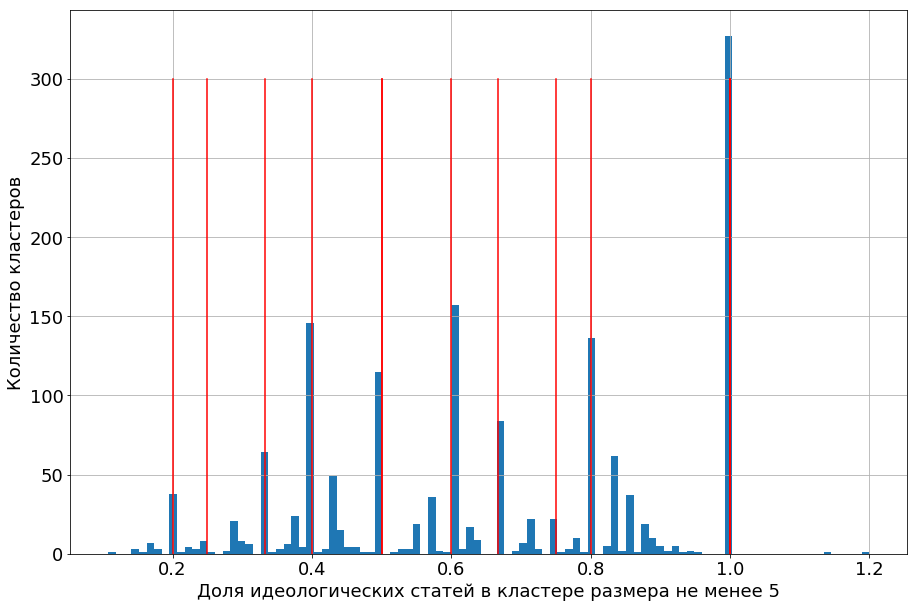

In [240]:
plot_ideological_hist(5, 100)
m = 300
for denumerator in range(1, 6):
    for numerator in range(1, denumerator + 1):
        p = numerator / float(denumerator)
        plt.plot([p, p], [0, m], 'r-')

Давайте построим гистограмму для кластеров размера не менее 6. Как видим, кластера кратные 5 исчезли. Этот факт подтверждает нашу гипотезу.

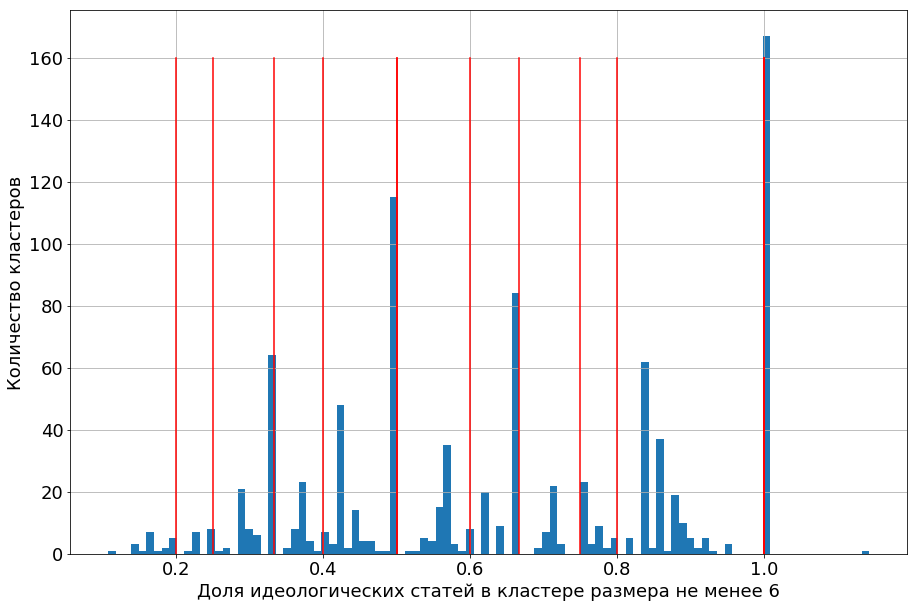

In [206]:
plot_ideological_hist(6, 100)
m = 160
for denumerator in range(1, 6):
    for numerator in range(1, denumerator + 1):
        p = numerator / float(denumerator)
        plt.plot([p, p], [0, m], 'r-')

Выберем все те кластера, в которых идеологи особо отличаются: пишут все статьи (точка 1.0 на графике).

In [207]:
ideological = []
t = 5
i = 0
for cluster in clusters[1:]:
    authors = []
    count = 0
    if len(cluster) < t:
        continue
    for name in cluster:
        authors += docs[name][ArxivTags.Authors]
        count += 1
    
    items = [item[1] for item in Counter(authors).items()]
    authors = [item[0] for item in Counter(authors).items()]
    argmax = np.argmax(items)
    if items[argmax] >= count:
        print(i + 1, authors[argmax], cluster)
        i += 1

1 W.-K.Park {'1207.0582', '1601.01915', '1601.01916', '1208.0641', '1304.3223', '1704.03582', '1409.1754', '1208.2063', '1308.3906', '1308.3905', '1208.5203', '1601.01911', '1707.03643', '1601.01914', '1207.0586', '1306.0265', '1404.2378', '1704.03583'}
2 C.D.Charalambous {'1701.01007', '1310.3085', '1302.3971', '1104.0862', '1604.01056', '1512.04514', '1210.1266', '1301.6520', '1604.02742', '1401.5828', '1210.2019', '1301.6522', '1304.6528', '1212.6643', '1604.01063', '1405.1593', '1204.2980'}
3 V.N.Soshnikov {'physics/9706041', '0801.0286', 'physics/0105040', 'physics/0111014', '0711.2782', 'physics/0612064', 'physics/0610220', '0708.0767', 'physics/0205035', 'physics/0208098', 'physics/9712013', '0708.0748', '0709.2206', 'plasm-ph/9511001', '0711.1321'}
4 V.Kurasov {'cond-mat/0412141', '0808.2999', 'cond-mat/9310005', '1302.5064', '0801.0239', 'cond-mat/0505738', 'cond-mat/0410616', '0901.3437', 'cond-mat/0410774', '1301.1915', '0711.4559', '0801.0242', '1011.3543', 'cond-mat/060776

Для детального анализа кластеров, я буду брать первую статью из кластера и проводить её поверхностный анализ. Если она мне будет казаться подозрительной, то я буду брать ещё несколько. Будем делить кластеры на "подозрительные" и не "подозрительные" с целью детекции тех наборов статей, которые сильно выбиваются массы.

### Рассмотрим НЕ "подозрительные" кластеры:

Рассмотрим 1 кластер. Его образует идеолог Won-Kwang Park. В ссылках часто фигугирует H. Ammari:

* https://arxiv.org/pdf/1207.0586.pdf

* https://arxiv.org/pdf/1707.03643.pdf

* https://arxiv.org/pdf/1601.01916.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.

_________________

Рассмотрим 2 кластер. Идеолог в данном кластере является Charalambos D. Charalambous

* https://arxiv.org/pdf/1701.01007.pdf
* https://arxiv.org/pdf/1310.3085.pdf
* https://arxiv.org/pdf/1302.3971.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.
_________________

Рассмотрим 3 кластер. Идеолог в данном кластере является Сошников.

https://arxiv.org/pdf/physics/9706041.pdf

Статьи кажутся вполне вменяемыми. Кроме того, они ссылаются на различные источники, которые не фигурируют на arxiv.

### Рассмотрим *подозрительные* кластеры:
_________________

Приведём пример *подозрительного* 6го кластера. 

* https://arxiv.org/pdf/quant-ph/0411060.pdf
* https://arxiv.org/pdf/quant-ph/0506074.pdf
* https://arxiv.org/pdf/quant-ph/9906043.pdf
* https://arxiv.org/pdf/quant-ph/0503059.pdf
* https://arxiv.org/pdf/quant-ph/0411060.pdf

Идеолог: https://www.researchgate.net/profile/Habatwa_Mweene

Идеолог данных работ ссылается, в подавляющем большинстве случаев только на 1 автора. Немного смущает, что этот человек из Замбии. Я не расист, но всё-таки.

_________________

Ещё один *подозрительный* 7ый кластер. Идеолог рассуждает о странных исторических объектах, а также иногда ссылается на википедию, как на достоверный источник

* https://arxiv.org/pdf/1107.5831.pdf
* https://arxiv.org/pdf/1204.6497.pdf
* https://arxiv.org/pdf/1205.0706.pdf

Идеолог: A.C.Sparavigna
_________________

Ещё один *подозрительный* 10ый кластер. Идеолог рассуждает о Фурье и функциях комплексного аргумента. Есть ссылки на вики и очень много ссылок на свои же статьи. Это настораживает.

* https://arxiv.org/pdf/1409.2582.pdf
* https://arxiv.org/pdf/1710.10947.pdf
* https://arxiv.org/pdf/1708.07017.pdf

Идеолог: Jorge L.deLyra


_________________

13ый кластер. Идеолог говорит о [новом принципе в физике](https://arxiv.org/pdf/0812.4343.pdf). В ряде статейесть ссылки только на свои статьи. Вызывает сомнения, что автор ссылается на очень древние работы (1946, 1935 года). Если же работы не его, то часто это могут быть монографии и значимой ссылкой это вряд ли может быть.

* https://arxiv.org/pdf/0812.4343.pdf
* https://arxiv.org/pdf/physics/0312043.pdf
* https://arxiv.org/pdf/cond-mat/0412396.pdf
* https://arxiv.org/pdf/0904.2911.pdf
* https://arxiv.org/pdf/physics/0006038.pdf

Идеолог: C.Y.Chen


_________________

14ый кластер. Работа по социологии. Крайне много ссылок в каждой статье. Человек публикует 3-4 статьи в год. При этом делает это в одиночку. Это настораживает.

* https://arxiv.org/pdf/1601.01222.pdf
* https://arxiv.org/pdf/1411.0092.pdf
* https://arxiv.org/pdf/1508.01869.pdf
* https://arxiv.org/pdf/1506.01821.pdf
* https://arxiv.org/pdf/physics/0006038.pdf

Идеолог: V.D.Florio


_________________

21ый кластер. Человек публикуется в одиночку, при этом, за год успевает сделать 3-4 работы. Но в работах присутствуют ссылки на работы других людей (не arxiv). 

* https://arxiv.org/pdf/1007.5434.pdf
* https://arxiv.org/pdf/0912.5091.pdf
* https://arxiv.org/pdf/1002.1414.pdf

Идеолог: D.Z.Djokovic

### Выводы

Таким образом, я проанализировал 50 первых кластеров из 329. Из них всего 6 оказались, действительно, с особенностями. Остальные же не представляли собой интерес с этой точки зрения. Я заострил внимание на том, что люди могут публиковать много статей за год, действуя в одиночку. В нескольких случаях люди исследовали очень странные вещи, а также ссылались либо только на свои статьи, либо на свои статьи, монографии и древние работы (например, 1936 года). 

В связи с этим, можно заключить, что малые кластеры (те, в которых более 4 статей) образованы, как правило, в связи с тем, что статьи ссылаются на внешние источники (не arxiv), либо же из-за того, что ссылки на статьи arxiv не были распознаны (авторы датасета в личной переписке сказали, что ссылки статей друг на друга формировались на основе эвристик, задаваемых регулярными выражениями).

Кластеры, в которых оказываются 4 и менее статьи, могли образоваться по тем же причинам, либо же, образоваться из-за того, что 

### Кластеры менее чем из 5 статей

In [236]:
print('Число кластеров из 1 статьи:', len([1 for c in clusters if len(c) == 1]))
print('Число кластеров из 1 статьи:', len([1 for c in clusters if len(c) == 1]) / len(docs))
print('Всего кластеров менее чем из 5 статей:', len([1 for c in clusters if len(c) < 5]))

Число кластеров из 1 статьи: 302293
Число кластеров из 1 статьи: 0.2250163202019909
Всего кластеров менее чем из 5 статей: 319367


Таким образом, почти все мелкие кластеры образованы отдельными статьями. Число таких статей равно $22,5\%$. Это довольно много. Причин образования единичных кластеров может быть несколько. Наиболее вероятные из них:

* Автор написал единственную статью когда-то в прошлом
* Автор написал единственную статью и ещё не успел написать других статей
* Автор написал много статей, но мало публиковал на arxiv (т.е. есть ссылки на внешние источники)
* Погрешность при составлении датасета
* Агрегация всех вышеперечисленных причин

Помимо единичных кластеров, есть кластеры, образованные 2-4 статьями. Давайте попробуем понять, почему возникают такие объекты. Для этого посмотрим, разницу между первой публикацией в рамках кластера и последней. Построим гистограмму для этой характеристики:

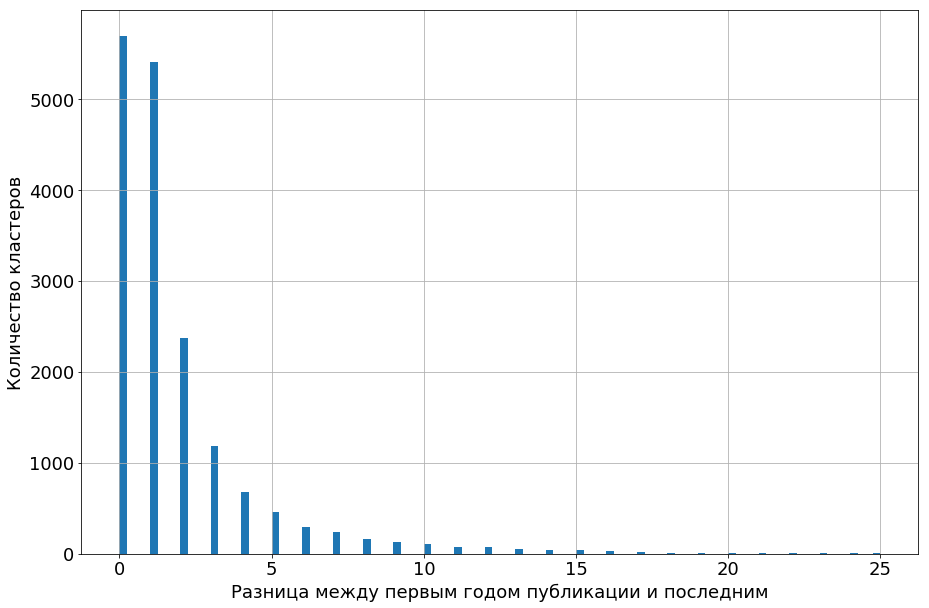

In [242]:
years_all = []
c = []
t = 5
i = 0
for cluster in clusters[1:]:
    years = []
    count = 0
    if len(cluster) >= t or len(cluster) < 2:
        continue
    for name in cluster:
        years.append(docs[name][ArxivTags.Year])
    years_all.append((max(years) - min(years)))
    if (max(years) - min(years)) != 0:
        c.append(cluster)
        
plt.figure(figsize=(15, 10))
plt.hist(years_all, bins=100)
plt.ylabel('Количество кластеров', fontsize=18)
plt.xlabel('Разница между первым годом публикации и последним', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

Таким образом, видим, что добрая половина всех кластеров, состоящих из 2-4 статей содержат в себе статьи, которые были опубликованы в один год, либо же в 2 года подряд. Это косвенно указывает на то, что:

* Автор написали несколько статьей когда-то в прошлом и больше не пишут статьи по данной теме
* Авторы написали несколько статьей и ещё не успели написать других статей

Нельзя также исключать и других причин:

* Автор написал много статей, но мало публиковал на arxiv (т.е. есть ссылки на внешние источники)
* Погрешность при составлении датасета

Но они менее вероятны.

# Раздел 2. Рассчёт различных характеристик графа

Прежде чем идти дальше, оговоримся, нас будет интересовать, как меняется та или иная характеристика с ростом числа вершин. При этом, увеличивать число вершин будем двумя способами:

1. Случайно выбираем подграф размера $n$
2. Отсортируем все вершины в порядке их появления в графе. Будем выбирать первые $n$ вершин

Всюду ниже, если не оговаривается обратного, строим ориентированный граф. Также будем строить ориентированный граф гигантской компоненты связности, ибо именно она представляет основной интересно. Все же более мелкие компоненты будут лишь усложнять анализ, а также менее представительны и, как мы выяснили выше, скорее всего являются особенностью данных и представляют небольшой интерес. Для чистоты эксперимента, также уберём мелкие категории *eess, econ*, поскольку они не информативны.

Первый способ необходим для понимания того, как граф ведёт себя в стационарном состоянии, а значит, как будет вести себя при масштабировании. Второй способ позволит анализировать эволюцию графа.

Рассмотрим первый способ.

*Замечание*: большинство из выдвинутых гипотез относительно интерпретаций структур графа, являются предположениями автора и требуют детального исследования текстов работ, что данный датасет не позволяет сделать. Эти гипотезы выдвинуты в рамках дедуктивных рассуждений и получения некоторых характеристик, которые мы измерим для графа. При этом, структурные свойства, которыми обладает граф, будут проверены и их можно воспринимать как достоверные.

### Паттерны в графах. Число треугольников

Как легко понять, треугольники в неориентированном графе нас мало интересуют, так как ссылочный граф представляет интерес в том случае, когда есть соответствие $A \rightarrow B$ (ссылается). Более того, $B$, как правило ничего не знает про $A$, поэтому для связи $A \rightarrow B$ обратная связь не имеет смысла.

Но ради интереса, давайте понаблюдаем, как меняется число треугольников (неориентированного графа) в зависимости от числа вершин. Для того, чтобы не подсчитывать число треугольников в полном графе, будем рассчитывать их количество для $10 \%$ вершин. Будем это делать так:

1. Выберем случайный подграф размера $n$
2. Выберем случайную вершину $v_0$ этого подграфа
3. Переберём всех соседей $v_1$ вершины $v_0$
4. Для каждой вершины $v_1$ переберём всех её соседей $v_2$.
5. Посчитаем, сколько троек $(v_0, v_1, v_2)$ образуют треугольник (т.е. имеют связи) и выберем среди них все неупорядоченные уникальные тройки

Будем выполнять пункты 2-5 для $10\%$ вершин без их повторений. После чего посчитаем суммарное число троек. Аналогичный алгоритм будем применять для подсчёта других характеристик. Разумеется, число треугольников мы будем подсчитывать для неориентированного графа.

In [ ]:
del docs
del G

In [2]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:23<00:00,  2.16s/it]


In [3]:
remove_noise_tags(docs)

In [4]:
G = nx.Graph()
for doc in tqdm_notebook(docs, desc='Построение графа'):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

In [3]:
def custom_plot(x, y, title, ylabel, text, xlabel='Число вершин', font=18, title_font=24, linewidth=4, markersize=10):
    plt.plot(x, y, 'b-', linewidth=linewidth)
    plt.plot(x, y, 'ro', markersize=markersize)
    plt.title(title, fontsize=title_font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel(xlabel, fontsize=font)
    plt.ylabel(ylabel, fontsize=font)
    plt.text(x[-1], y[-1], text, fontsize=font)
    plt.grid(True)
    
def count_metric(G, metric, desc, proporion, sizes_subgraph, is_save_objs=False, random_state=42):
    all_objs = []
    vertexes = list(G.nodes)
    np.random.seed(random_state)
    for n in tqdm_notebook(sizes_subgraph, desc=desc):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = list(np.array(vertexes)[perm])[:n]
        subgraph = G.subgraph(random_vertex)
        objs = []
        for v in random_vertex[:int(n * proporion)]:
            objs += metric(subgraph, v)
        if is_save_objs:
            all_objs.append(list(set(objs)))
        else:
            all_objs.append(len(set(objs)))
    return all_objs

In [4]:
def get_triangle(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        for v2 in G.neighbors(v1):
            if v2 == v0:
                vertexes.append('~'.join(sorted((v0, v1, v2))))
    return vertexes

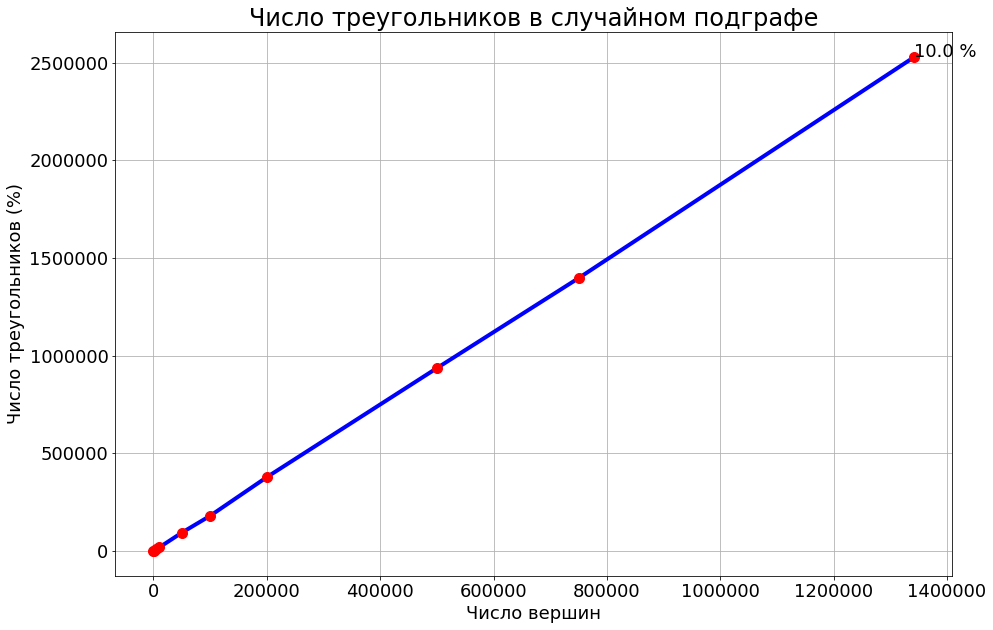

In [7]:
proportion = 0.1
sizes_subgraph = [5, 100, 5000, 10000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
count_K3 = count_metric(G, get_triangle, 'Подсчёт числа треугольников', proportion, sizes_subgraph)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_K3,
    'Число треугольников в случайном подграфе',
    'Число треугольников (%)',
    str(proportion * 100) + ' %'
)

Легко можно подсчитать число треугольников для полного графа составлением простого отношения. Их, очевидно, будет в 10 раз больше.

In [8]:
del count_K3
del sizes_subgraph

Число треугольников растёт линейно в зависимости от числа вершин. Этот важный факт означает, что эта характеристика не изменяется в среднем для различных подмножеств графа одинакового размера и "плотность" треугольников в любой области графа одинаковая.

Куда интереснее другие характеристики.

### Диполи

Начнём с диполей, т.е. двух вершин, которые ссылаются друг на друга. Что это может означать? Одной из возможных интерпретаций такой структуры, является **повышение индекса цитирования**. Или, иными словами, это можно расценивать как мошеннические действия со стороны авторов. Другим вариантом является укрепление аргументации в свою пользу, что, на самом деле, тоже можно расценить как вариант мошенничества. Детальнее можно почитать [здесь](http://blogs.discovermagazine.com/neuroskeptic/2014/10/12/what-drives-academic-citations/#.XAcS38szY5k), [здесь](https://www.researchgate.net/publication/260600655_A_taxonomy_of_motives_to_cite) и [здесь](https://writing-skills-development.blogspot.com/2015/11/dlja-chego-uchenye-ssylajutsja-drug-na-druga.html). Если копнуть глубже, то такие ситуации (да, и вообще, ситуации с циклами) кажутся крайне странными: по сути мы имеем ссылку в будущее. То есть автор ссылается ещё на неопубликованную статью. 

Покажем это для $n$ вершин. Пусть у нас есть последовательность вершин: $v_0, v_1, v_2, v_3 \cdots v_{n-1}$, которые образуют цикл. Каждая вершина имеет метку, связанную с датой выхода работы. Будем идти по этим вершинам начиная с $v_0$ до тех пор, пока $t_i \leq t_{i+1}$. Но в какой-то момент, мы придём в исходную вершину, для которой уж точно не будет выполняться $t_{n-1} \leq t_0$ (возможно, это произойдёт раньше). ЧТД. Таким образом, это выполняется и для $n=2$.

Кажется, что если такие статьи существуют, то они должны находиться рядом друг от друга во времени.

Третьим объяснением может являться, опять же, принцип обработки датасета: ошибки в построении ребёр и графа. 

Вершины, которые входят в диполь, будем называть $f_2$ (от англ. fraud). Сами структуры (диполи) -- $F_2$. Отметим, что далее слово *мошенник* и все его вариации будем использовать лишь как термин. Рассматривать его как характеристику человека смысла не имеет.

In [9]:
del G

In [ ]:
G = nx.DiGraph()
for doc in tqdm_notebook(docs, desc='Построение графа (ориентированный)'):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

In [11]:
def get_dipole(g, v0):
    vertexes = []
    for v1 in G.neighbors(v0):
        if v0 in G.neighbors(v1):
            vertexes.append('~'.join(sorted((v0, v1))))
    return vertexes

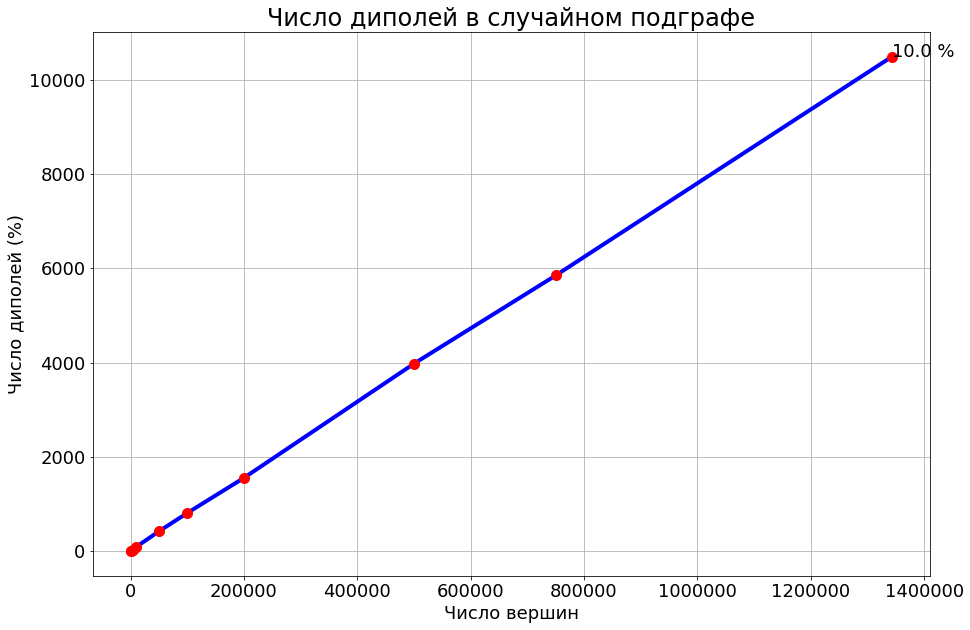

In [18]:
proportion = 0.1
sizes_subgraph = [5, 100, 5000, 10000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
count_direction_K2 = count_metric(G, get_dipole, 'Число диполей', proportion, sizes_subgraph)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_direction_K2,
    'Число диполей в случайном подграфе',
    'Число диполей (%)',
    str(proportion * 100) + ' %'
)

Видим линейную зависимость от числа вершин. Т.е. при разростании графа число структур $F_2$ увеличивается. При этом, важно, увеличение размеров графа никак не влияет на появление бо'льшего структур. Например, гипотетически, можно было бы предположить, что рост графа способствует появлению дополнительных связей (дополнительных диполей), тем самым увеличивая число структур $F_2$. Но этого, как мы видим, не происходит, что, в принципе, закономерно. Другое дело, требуется исследовать вопрос роста таких связей во времени, т.е. при добавлении вершин в хронологическом порядке. Этот аспект мы будем исследовать ниже.

Считая, что число $F_2$ для полного графа будет в 10 раз больше, легко понять, число рёбер, которые входят в диполи, будет ещё в 2 раза больше. Тогда окажется, что почти $2\%$ ребер входят в диполи:

In [19]:
print('Число ребёр в диполях полного графа: %f' % (2. * count_direction_K2[-1] * 10 / len(G.edges)))

Число ребёр в диполях полного графа: 0.016532


Кажется, что это довольно много для погрешности при обработке графа. Обработаем весь граф и вытащим всех авторов, у которых есть такие статьи.

In [20]:
del count_direction_K2
del sizes_subgraph

In [69]:
del vertexes

In [ ]:
proportion = 1
sizes_subgraph = [len(G.nodes)]
loops = count_metric(G, get_dipole, 'Собираем информацию о всех вершинах', proportion, sizes_subgraph, True)

Давайте теперь посмотрим, как же устроено распределение авторов, статьи которых являются вершинами $f_2$. Легко догадаться, как оно будет выглядеть:

In [130]:
temp_loops = []
for doc in loops[0]:
    doc0 = doc.split('~')[0]
    doc1 = doc.split('~')[1]
    temp_loops.append(doc0)
    temp_loops.append(doc1)

temp_loops = list(set(temp_loops))

authors = []
for doc in temp_loops:
    authors += docs[doc][ArxivTags.Authors]
    
del temp_loops

authors = Counter(authors)
count_papers = []
for key in authors:
    count_papers.append(authors[key])    

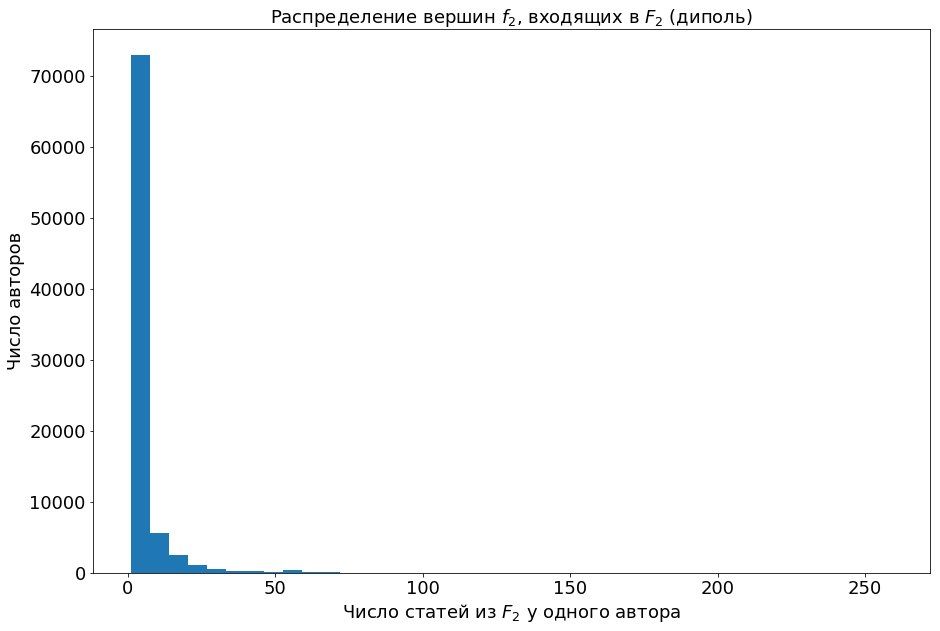

In [123]:
plt.figure(figsize=(15, 10))
plt.hist(count_papers, bins=40)
plt.xlabel('Число статей из $F_2$ у одного автора', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение вершин $f_2$, входящих в $F_2$ (диполь)', fontsize=18);
plt.grid(True);

Очевидно, что есть большое количество авторов, которые породили лишь небольшое количество вершин $f_2$ (либо же, ссылка была неверно сформирована в процессе построения датасета). Все они, с большой долей вероятности находятся в спайке около нуля. Попробуем это проанализировать. Для начала, взглянем на распределение пристальнее:

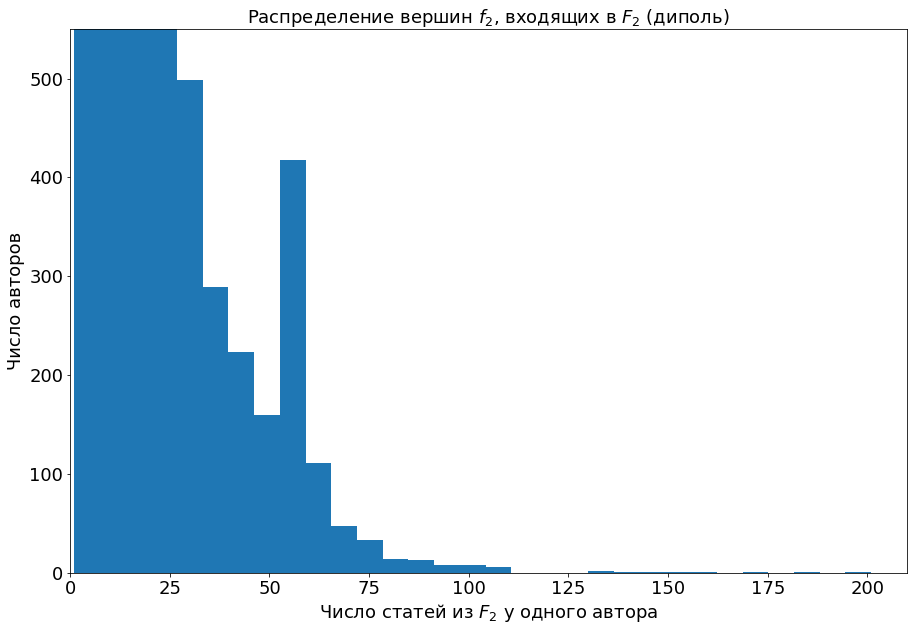

In [124]:
plt.figure(figsize=(15, 10))
plt.hist(count_papers, bins=40)
plt.xlabel('Число статей из $F_2$ у одного автора', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение вершин $f_2$, входящих в $F_2$ (диполь)', fontsize=18)
plt.xlim([0, 210])
plt.ylim([0, 550]);
plt.grid(True);

Относительно большое количество авторов присутствует в хвосте распределения. У некоторых из них более 150 статей!!! 150, Карл!!! Это потрясающе. 150 статей, которые ссылаются друг на друга.

На гистограмме также заметен выброс. Давайте ещё помельче нарежем гистограмму и взглянем на неё. 

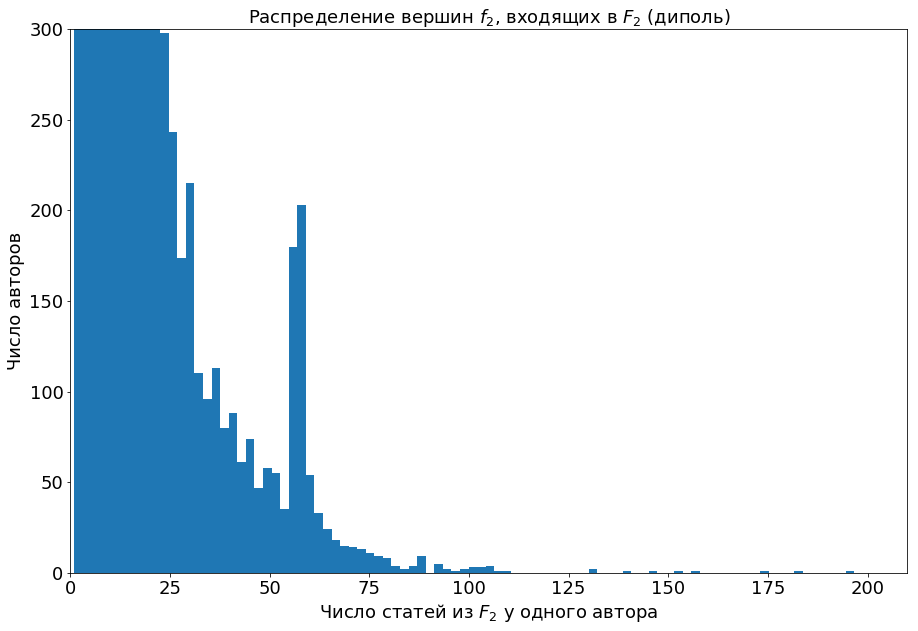

In [125]:
plt.figure(figsize=(15, 10))
plt.hist(count_papers, bins=120)
plt.xlabel('Число статей из $F_2$ у одного автора', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение вершин $f_2$, входящих в $F_2$ (диполь)', fontsize=18);
plt.xlim([0, 210])
plt.ylim([0, 300]);
plt.grid(True);

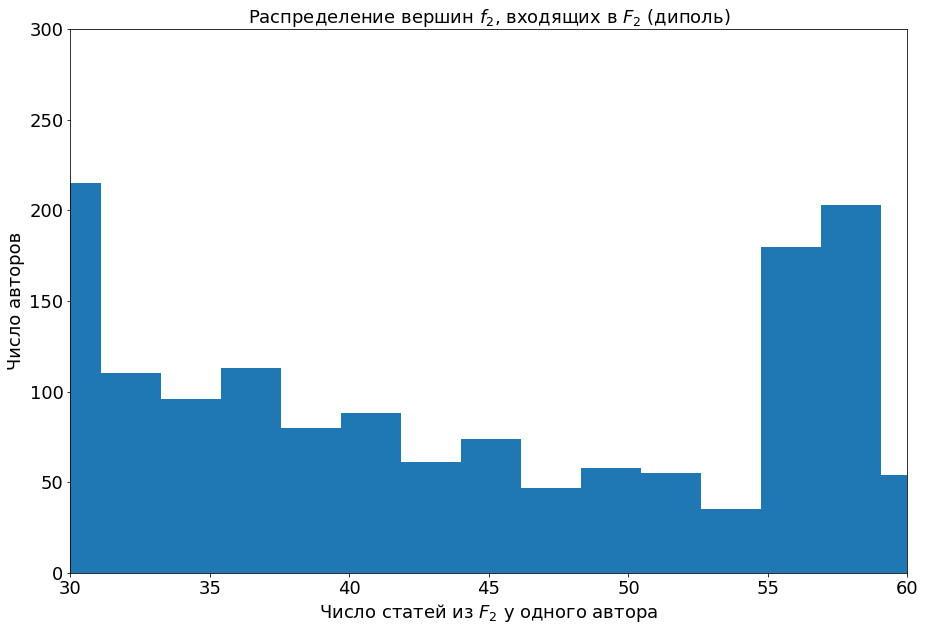

In [131]:
plt.figure(figsize=(15, 10))
plt.hist(count_papers, bins=120)
plt.xlabel('Число статей из $F_2$ у одного автора', fontsize=18)
plt.ylabel('Число авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение вершин $f_2$, входящих в $F_2$ (диполь)', fontsize=18);
plt.xlim([30, 60])
plt.ylim([0, 300]);
plt.grid(True);

In [132]:
del count_papers

Теперь возмём нескольких авторов и изучим их работы, входящие в $F_2$ (диполи). Мы хотим понять следующие факты:

* Изучить отдельные работы авторов на предмет вхождения в диполи (возможно, это ошибки в графе)
* В каком году впервые появились $F_2$ и как они распределены во времени

Ответим на первый вопрос. **Изучить отдельные работы авторов на предмет вхождения в диполи**. Возьмём нескольких авторов из отрезка [1; 4] статей. Возьмём несколько авторов из отрезка [5; 30] статей. Аналогично рассмотрим отрезок [80; 120] статей.

#### Отрезок [1;5]

Возьмём следующих авторов

In [105]:
target_authors = '''
M.Henze
J.-U.Ness 
S.C.Williams
A.W.Shafter
K.Hornoch
V.Votruba
W.M.Wieland
J.Tambornino
X.Zambrana-Puyalto
N.Tischler
A.Minovich
X.Vidal
F.T.-H.Fong
Th.Zink
A.Mihatsch
A.G.Kosovichev
R.Bogart
T.L.D.Jr
'''.split('\n')[1:-1]

Выведем все диполи, в которых они состоят.

In [106]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
N.Tischler 1212.3601 -> 1304.2829
X.Vidal 1212.3601 -> 1304.2829
X.Zambrana-Puyalto 1206.0868 -> 1206.5563
X.Zambrana-Puyalto 1206.5563 -> 1206.0868
N.Tischler 1206.0868 -> 1206.5563
A.Minovich 1206.0868 -> 1206.5563
X.Vidal 1206.0868 -> 1206.5563
W.M.Wieland 1107.5002 -> 1107.5274
A.G.Kosovichev 1010.4927 -> 1011.0799
A.G.Kosovichev 1011.0799 -> 1010.4927
R.Bogart 1011.0799 -> 1010.4927
T.L.D.Jr 1011.0799 -> 1010.4927
M.Henze 1401.2905 -> 1401.2426
S.C.Williams 1401.2905 -> 1401.2426
A.W.Shafter 1401.2905 -> 1401.2426
K.Hornoch 1401.2905 -> 1401.2426
V.Votruba 1401.2905 -> 1401.2426
M.Henze 1401.2904 -> 1401.2905
M.Henze 1401.2905 -> 1401.2904
S.C.Williams 1401.2904 -> 1401.2905
S.C.Williams 1401.2905 -> 1401.2904
A.W.Shafter 1401.2904 -> 1401.2905
A.W.Shafter 1401.2905 -> 1401.2904
K.Hornoch 1401.2905 -> 1401.2904
V.Votruba 1401.2905 -> 1401.2904
F.T.-H.Fong 1104.3924 -> 1107.2144
W.M.Wieland 1207.6348 -> 1204.5394
F.T

Рассмотрим статьи [1401.2904](https://arxiv.org/pdf/1401.2904.pdf) и [1401.2905](https://arxiv.org/pdf/1401.2905.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Названия статей практически одинаковые: 

* A remarkable recurrent nova in M 31 - The X-ray observations
* A remarkable recurrent nova in M31 - The optical observations

Я не силён в физике, но кажется, что статьи очень близки по содержанию и скорее всего изучают близкие явления. Более того, они были опубликованы друг за другом. При этом, это не умоляет того, что авторы допустили такой хак. Следует отметить, что обе статьи публиковала одна и та же группа учёных.

________________

Рассмотрим статьи [1401.2426](https://arxiv.org/pdf/1401.2426.pdf) и [1401.2905](https://arxiv.org/pdf/1401.2905.pdf) (та же статья, что и в предыдущем пункте). Ссылки в прошлое и будущее соответсвенно, есть. Здесь статьи были опубликованы в разное время. Скорее всего, они отстаят друг от друга на несколько дней. При этом, стоит принимать во внимание тот факт, что статьи могли публиковаться в каком-нибудь журнале одновременно. В связи с этим вышел такой коллапс. Но, опять же, это не уменьшает вины авторов.

В отличие от первых двух статей, здесь диполь образован двумя различными группами учёных. А значит, это люди, скорее всего, действовали в сговоре.

________________

Идём далее. Рассмотрим статьи [1107.5002](https://arxiv.org/pdf/1107.5002.pdf) и [1108.0369](https://arxiv.org/pdf/1108.0369.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Опять же, на лицо явный сговор авторов. Плюс к этому, стоит отметить, что статьи были опубликованы в разные месяцы. Та, что раньше опубликована 29 июля 2011. Та, что позже 1 августа 2011.

________________

Идём далее. Рассмотрим статьи [1107.5002](https://arxiv.org/pdf/1107.5002.pdf) и [1107.5274](https://arxiv.org/pdf/1107.5274.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Опять же, на лицо явный сговор авторов. Плюс к этому, стоит отметить, что статьи были опубликованы в разные месяцы. Та, что раньше опубликована 29 июля 2011. Та, что позже 1 августа 2011. Статью 1107.5274 написала та же группа авторов, что и 1108.0369. Опять же, налицо очевидный сговор двух групп авторов.

________________

До селе мы рассматривали только лишь статьи, которые отстоят друг от друга на несколько дней. Теперь же рассмотрим 2 статьи, разница между которыми больше года. [1611.06520](https://arxiv.org/pdf/1611.06520.pdf) и [1408.4071](https://arxiv.org/pdf/1408.4071.pdf). Ссылки в прошлое и будущее соответсвенно, есть. Данную особенность тяжело объяснить. Как возникают такие ссылки не до конца понятно. Возможно, это связано с тем, что статьи прежде публикуются в журналах, а лишь потом выкладываются на arxiv. Т.е. статья 1611.06520 на самом деле -- это статья 2014 года, также как и статья 1408.4071. В таком случае это становится объяснимым. Но беглые поиски в гугле не принесли результатов. Аналогичную статью от 2014 года найти не удалось. Так что этот вопрос остаётся открытым.

Как видим, все ссылки построены верно (из тех работ, что мы рассматривали). Авторы, действительно, ссылаются друг на друга в прошлое и будушее. Причин этого эффекта до конца не ясны. Опустим анализ оставшихся работ, поскольку, они скорее всего выглядят похожим образом.

#### Отрезок [6;30]

In [110]:
target_authors = '''
M.Kato
I.Hachisu
E.R.Livine
'''.split('\n')[1:-1]

Выведем все работы авторов:

In [111]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
M.Kato cond-mat/0306036 -> cond-mat/0505380
M.Kato cond-mat/0306036 -> cond-mat/0503233
E.R.Livine hep-th/0512113 -> gr-qc/0604016
E.R.Livine 1004.0621 -> 1003.2108
E.R.Livine 1103.3415 -> 1108.1569
E.R.Livine gr-qc/0508085 -> hep-th/0409056
E.R.Livine 1107.5274 -> 1107.5002
E.R.Livine 1103.3415 -> 1101.3524
M.Kato 1511.01608 -> 1703.08980
I.Hachisu astro-ph/0011003 -> astro-ph/0105127
E.R.Livine 1504.02822 -> 1312.5646
E.R.Livine 1207.0416 -> 1303.6772
M.Kato cond-mat/0306036 -> cond-mat/0510051
M.Kato 1511.01608 -> 1702.03074
M.Kato 0805.2102 -> 0804.0909
I.Hachisu 0805.2102 -> 0804.0909
E.R.Livine 1207.0416 -> 1301.1535
M.Kato 0710.0319 -> 0711.2570
I.Hachisu 0710.0319 -> 0711.2570
M.Kato 1709.05468 -> 1704.05148
M.Kato 1401.2904 -> 1401.2905
I.Hachisu 1401.2904 -> 1401.2905
M.Kato 1511.01608 -> 1612.03643
E.R.Livine 1207.0416 -> 1207.6734
M.Kato 1106.3510 -> 1106.2027
I.Hachisu 1106.3510 -> 1106.2027
E.R.Livine 0708.

Наблюдаем, что некоторые авторы работ 1401.2904, 1401.2905 (см. предыдущий пункт про отрезок [1; 5]): M.J.Darnley, M.F.Bode, M.Kato, I.Hachisu прибегают к ухищрениям чаще своих коллег. Для того, чтобы подтвердить, что и в этом подмножестве есть аналогичные связи, рассмотрим, например, работы:

[1111.2867](https://arxiv.org/pdf/1111.2867.pdf) и [1205.2019](https://arxiv.org/pdf/1205.2019.pdf). Ничего неожиданного. Авторы ссылают друг на друга. Как легко предположить, авторы ссылаются на статьи друг друга не только в указанных работах. Но и в других.

В связи с этим, возникает интересный вопрос: было бы замечательно научиться выделять группы авторов, который друг на друга ссылаются.

В процессе анализа, были выявлены интересные особенности. Мы нашли автора P.Carvalho.

In [112]:
authors['P.Carvalho']

9

In [128]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
P.Carvalho 1303.5080 -> 1303.5082
P.Carvalho 1303.5088 -> 1303.5067
P.Carvalho 1101.2024 -> 1101.2025
P.Carvalho 1303.5080 -> 1303.5076
P.Carvalho 1502.01582 -> 1506.07135
P.Carvalho 1303.5080 -> 1303.5086
P.Carvalho 1507.02058 -> 1507.02058
P.Carvalho 1507.02058 -> 1507.02058
P.Carvalho 1502.01582 -> 1502.01589
P.Carvalho 1101.2041 -> 1101.2026
P.Carvalho 1303.5088 -> 1303.5065
P.Carvalho 1101.2024 -> 1101.2026
P.Carvalho 1507.02058 -> 1502.01593
P.Carvalho 1507.02058 -> 1506.07135
P.Carvalho 1502.01582 -> 1505.08022
P.Carvalho 1303.5088 -> 1303.5074
P.Carvalho 1303.5089 -> 1303.5063
P.Carvalho 1507.02058 -> 1509.06348
P.Carvalho 1303.5088 -> 1306.3470
P.Carvalho 1502.01582 -> 1502.01595
P.Carvalho 1303.5080 -> 1303.5066
P.Carvalho 1303.5088 -> 1303.5066
P.Carvalho 1303.5080 -> 1303.5067
P.Carvalho 1101.2041 -> 1101.2028
P.Carvalho 1303.5080 -> 1303.5064
P.Carvalho 1303.5088 -> 1303.5070
P.Carvalho 1303.5080 -> 1303.508

Рассмотрим работы [1506.07135](https://arxiv.org/pdf/1506.07135.pdf) и [1502.01582](https://arxiv.org/pdf/1502.01582.pdf). Данные статьи представляют собой, судя по всему, результаты конференции (*Planck 2015 results*). Работы содержат безумное количество участников (их явно больше 200). Как получилось так, что они дают ссылки в прошлое можно только предполагать. Например, журналы публиковались в одно и то же время и ссылки были указаны примерно в одном и том же промежутке времени. Но цель таких ссылок не ясна. Скорее всего, в данном случае это объясняется обстоятельствами или принятыми правилами публикации статей. С другой стороны, других подобных конференций мной найдено не было, поэтому закрадываются некоторые сомнения.

Возвращаюсь к спайку, который мы увидели на гистограмме с большим числом разбиений, можно предположить, что он возник по аналогичной причине: публикация журнала породила большое количество ссылок у одних и тех же авторов. В связи с этим, возник такого рода эффект. Но подтвердить это не удалось.

Заметим, что P.Carvalho имеет только 9 статей. Таким образом, вероятно, этот человек за счёт участия в крупной конференции, мог бы получить большой индекс цитирования.

Интересная особенность заключается в том, что одна из статей ссылается сама на себя: [1101.2026](https://arxiv.org/pdf/1101.2026.pdf). Как Вы думаете, какое у неё название? Конечно же это та же конференция. *Planck Early Results XI: Calibration of the local galaxy cluster. Sunyaev-Zeldovich scaling relations*. Для чего авторы статей проделывают такие трюки непонятно. 

#### Отрезок [80;120]

In [133]:
count = 5
target_authors = []
print('Авторы:')
for k in authors:
    if authors[k] >= 80 and authors[k] <= 120 and count > 0:
        print(k)
        target_authors.append(k)
        count -= 1

Авторы:
V.Springel
D.Scott
L.Wang
T.Li
R.C.Nichol


In [134]:
print('Формат: Автор  Статья автора -> ссылка на вторую статью из диполя')
for doc in vertexes[0]:
    for author in target_authors:
        doc0 = doc.split('~')[0]
        doc1 = doc.split('~')[1]
        if author in set(docs[doc0][ArxivTags.Authors]):
            print(author, doc0, '->', doc1)
        if author in set(docs[doc1][ArxivTags.Authors]):
            print(author, doc1, '->', doc0)

Формат: Автор  Статья автора -> ссылка на вторую статью из диполя
L.Wang astro-ph/9804285 -> astro-ph/9806362
D.Scott 1502.01591 -> 1507.02704
D.Scott 1507.02704 -> 1502.01591
T.Li 1201.5305 -> 1202.6088
T.Li 1202.6088 -> 1201.5305
L.Wang 1601.00534 -> 1601.00836
D.Scott 1303.5064 -> 1303.5086
D.Scott 1303.5086 -> 1303.5064
D.Scott 1502.01589 -> 1507.02058
D.Scott 1507.02058 -> 1502.01589
L.Wang 1701.04831 -> 1710.03545
D.Scott 1609.07263 -> 1612.00021
L.Wang 1305.5837 -> 1304.4595
V.Springel 0802.0228 -> 0908.3191
T.Li 1712.09586 -> 1712.02744
D.Scott 1101.2031 -> 1101.2032
D.Scott 1101.2032 -> 1101.2031
D.Scott 1502.01587 -> 1502.01592
D.Scott 1502.01592 -> 1502.01587
T.Li hep-ph/0202090 -> hep-ph/0202107
R.C.Nichol 1312.4877 -> 1401.4171
D.Scott astro-ph/9909092 -> astro-ph/9910428
D.Scott astro-ph/9910428 -> astro-ph/9909092
T.Li 1102.5644 -> 1111.7313
T.Li 1111.7313 -> 1102.5644
R.C.Nichol 1507.05552 -> 1507.05598
R.C.Nichol 1507.05598 -> 1507.05552
D.Scott 1509.05298 -> 1512.0674

D.Scott 1303.5065 -> 1303.5082
D.Scott 1303.5082 -> 1303.5065
T.Li 1107.2375 -> 1112.3024
T.Li 1112.3024 -> 1107.2375
D.Scott 1704.03143 -> 1709.10134
D.Scott 1709.10134 -> 1704.03143
D.Scott 1407.5452 -> 1409.1815
T.Li 1310.4101 -> 1310.8597
D.Scott 1101.2022 -> 1101.2028
D.Scott 1101.2028 -> 1101.2022
V.Springel 1405.3994 -> 1407.7858
T.Li 1405.1804 -> 1407.1819
T.Li 1407.1819 -> 1405.1804
D.Scott 1303.5074 -> 1303.5080
D.Scott 1303.5080 -> 1303.5074
D.Scott 1502.01584 -> 1505.08022
D.Scott 1505.08022 -> 1502.01584
D.Scott 1101.2032 -> 1101.2040
D.Scott 1101.2040 -> 1101.2032
V.Springel 1511.08804 -> 1511.08806
T.Li 1109.2110 -> 1111.4204
T.Li 1111.4204 -> 1109.2110
D.Scott 1101.2022 -> 1101.2041
D.Scott 1101.2041 -> 1101.2022
R.C.Nichol 1710.05459 -> 1710.05457
T.Li 1509.02185 -> 1409.3236
D.Scott 1303.5074 -> 1303.5086
D.Scott 1303.5086 -> 1303.5074
D.Scott 1101.2024 -> 1101.2026
D.Scott 1101.2026 -> 1101.2024
L.Wang 1503.04814 -> 1605.05323
L.Wang 1605.05323 -> 1503.04814
V.Spring

T.Li 1110.0451 -> 1110.0449
D.Scott 1511.06770 -> 1601.02665
D.Scott 1601.02665 -> 1511.06770
L.Wang 1511.06770 -> 1601.02665
L.Wang 1601.02665 -> 1511.06770
T.Li 1211.1504 -> 1211.0321
D.Scott 1502.01582 -> 1505.08022
D.Scott 1505.08022 -> 1502.01582
D.Scott 1007.5260 -> 1010.5782
D.Scott 1010.5782 -> 1007.5260
D.Scott 1303.5086 -> 1312.1300
D.Scott 1312.1300 -> 1303.5086
V.Springel astro-ph/0504156 -> astro-ph/0508167
V.Springel astro-ph/0508167 -> astro-ph/0504156
V.Springel astro-ph/0203342 -> astro-ph/0203004
V.Springel astro-ph/0307451 -> astro-ph/0310514
V.Springel astro-ph/0310514 -> astro-ph/0307451
T.Li 1005.3798 -> 1109.2329
T.Li 1109.2329 -> 1005.3798
D.Scott 1303.5063 -> 1303.5076
D.Scott 1303.5076 -> 1303.5063
D.Scott 1303.5063 -> 1303.5070
D.Scott 1303.5070 -> 1303.5063
D.Scott 1502.01582 -> 1502.01582
D.Scott 1502.01582 -> 1502.01582
L.Wang 1307.4746 -> 1303.2983
D.Scott 1502.01582 -> 1502.01583
D.Scott 1502.01583 -> 1502.01582
L.Wang 1304.6399 -> 1304.1270
T.Li hep-th/

T.Li 1109.2110 -> 1111.0236
T.Li 1111.0236 -> 1109.2110
R.C.Nichol 1707.09322 -> 1706.04240
D.Scott 1101.2026 -> 1101.2031
D.Scott 1101.2031 -> 1101.2026
T.Li 1107.3825 -> 1112.3024
T.Li 1112.3024 -> 1107.3825
D.Scott 1502.01583 -> 1502.02114
D.Scott 1502.02114 -> 1502.01583
D.Scott astro-ph/9605057 -> astro-ph/9607060
T.Li 1110.0451 -> 1109.5749
R.C.Nichol 1208.0022 -> 1210.5166
V.Springel astro-ph/0003162 -> astro-ph/9911025
T.Li 1102.5644 -> 1512.08780
T.Li hep-th/0501041 -> hep-th/0409032
D.Scott 1303.5083 -> 1303.5069
T.Li 1601.00866 -> 1512.05617
V.Springel 1707.03406 -> 1710.03240
D.Scott 1303.5088 -> 1303.5069
D.Scott 1101.2025 -> 1101.2028
D.Scott 1101.2028 -> 1101.2025
T.Li 1703.08474 -> 1709.07990
T.Li 1106.1165 -> 1111.0236
T.Li 1111.0236 -> 1106.1165
D.Scott 1303.5086 -> 1303.5086
D.Scott 1303.5086 -> 1303.5086
V.Springel astro-ph/0506038 -> astro-ph/0412034
D.Scott 1502.01592 -> 1505.08022
D.Scott 1505.08022 -> 1502.01592
T.Li 1107.2375 -> 1108.5169
T.Li 1108.5169 -> 1107

Большая часть статей из данной категории ссылается на конференцию по космологии разных лет и направлений, которая уже фигурировала выше. Но есть и интересное: две статьи по машинному обучению. [1709.01662](https://arxiv.org/pdf/1709.01662.pdf) и [1701.04831](https://arxiv.org/pdf/1701.04831.pdf) Статьи писались одними и теми же людьми. Но есть ссылки в будущее и прошлое, как мы это уже видели.

В заключение этой части, взглянем на распределение по годам $f_2$.

In [138]:
years = []
for doc in vertexes[0]:
    doc0 = doc.split('~')[0]
    doc1 = doc.split('~')[1]
    years.append(docs[doc0][ArxivTags.Year])
    years.append(docs[doc1][ArxivTags.Year])

In [168]:
x = []
y = []
for item in sorted(list(Counter(years).items()), key=lambda el: el[0]):
    x.append(item[0] % 100)
    y.append(item[1])

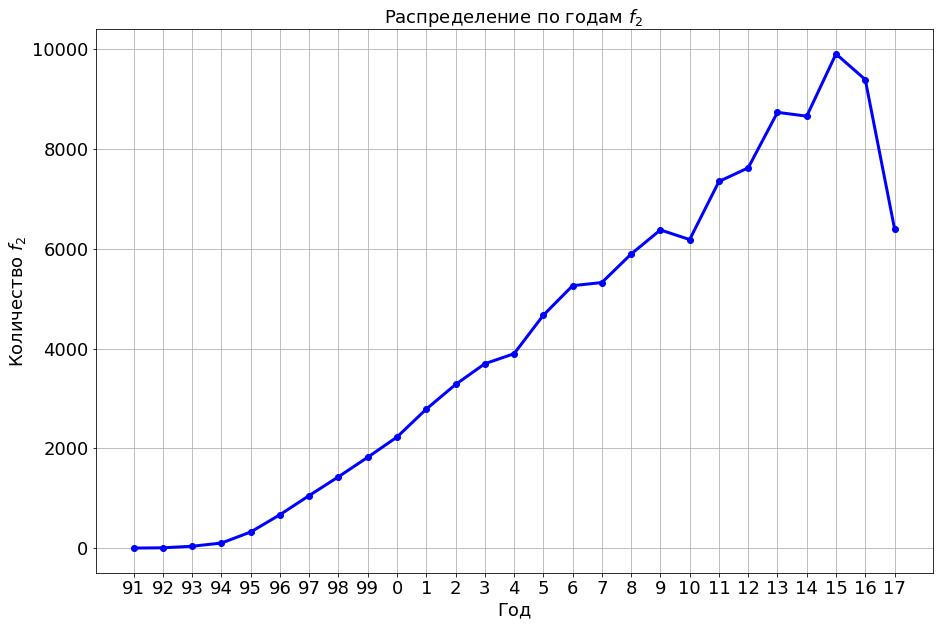

In [180]:
plt.figure(figsize=(15, 10))
plt.plot(list(range(len(x))), y, 'bo-', linewidth=3)
plt.xlabel('Год', fontsize=18)
plt.ylabel('Количество $f_2$', fontsize=18)
plt.xticks(list(range(len(x))), x, fontsize=18)
plt.yticks(fontsize=18)
plt.title('Распределение по годам $f_2$', fontsize=18)
plt.grid(True);

Число диполей со временем растёт. В 2017 году наблюдается спад, так как граф дан в полном объём лишь до сентебря 2017 года. В некоторые годы наблюдаются локальные спады числа новых диполей. Такая ситуация была в 2010 и 2014 годах. Ещё одной деталью, которую следовало бы изучить, является менее гладкая поверхность кривой, начиная с 2004-2007 годов. Я подозреваю, что это может быть связано со способом организации ссылок на сайте (начиная с 2007 года, подход к хранения ссылок arxiv изменился).

#### Выводы

Таким образом, заключаем. Авторы, действительно, ссылаются друг на друга в будущее и прошлое. Достоверно установить причину не удалось. Но есть несколько гипотез: 

* Авторы хотят увеличить индекс цитируемости, действуя в сговоре
* Авторы публикуются в журналах в одно и то же время, а на arxiv выкладывают работы позже. Такая гипотеза объяснила бы, почему ссылки в будущее/прошлое бывают на несколько лет, делая это, опять же, для повышения индекса цитируемости
* Прозаичный вариант: C'est la vie. Такова жизнь. Авторы, публикуя работы примерно в одно и то же время, непроизвольно оставляют ссылки друг на друга, априорно зная о том, что такие работы существуют. При этом, злого умысла у них нет
* Микс из всех вышеперечисленных идей в разных пропорциях

Что касается количества диполей для тех или иных авторов, то здесь можно отметить следующее:

* Определённый вклад привносят конференции. Оказывается, что есть много ссылок в прошлое и будущее. В частности, авторы, которые являются владельцами статей с более чем 100 ссылками, часто участвовали в конференции, например, по космологии. Возможно, есть и другие прецеденты. Но выявить их не удалось. Это мероприятие выглядит особенным. Почему авторы докладов с конференций ставят такие ссылки, остаётся загадкой. Возможно, по тем же корыстным причинам, что были описаны в самом начале раздела. 
* Авторы, которые порождают диполи (не в рамках статей по крупным конференциям), судя по всему, имеют, как правило, небольшое количество статей с диполями.

В заключение скажем, что подавляющее большинство ссылок-диполей корректно и граф составлен в этом отношении качественно. Число диполей со временем увеличвается.

In [132]:
del loops
del target_authors
del authors
del count_papers
del years

### Петли

Можно исследовать вопрос о наличии петель в графе. Как легко предположить, их число также растёт пропорционально числу вершин. Всякую вершину, которая обладает петлёй будем называть $f_1$. Будем называть $F_1$ такой паттерн (вершина и ребро).

In [2]:
def get_loop(g, v0):
    for v1 in G.neighbors(v0):
        if v0 == v1:
            return [v0]
    return []

In [7]:
docs = load_arxiv("paperscape-data-master/")

100%|██████████| 27/27 [00:21<00:00,  1.80s/it]


In [8]:
remove_noise_tags(docs)

In [9]:
G = nx.DiGraph()
for doc in tqdm_notebook(docs, desc='Построение графа (ориентированный)'):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        # Эти теги фигурируют в рёбрах, но таких вершин нет. Не будем их добавлять
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)

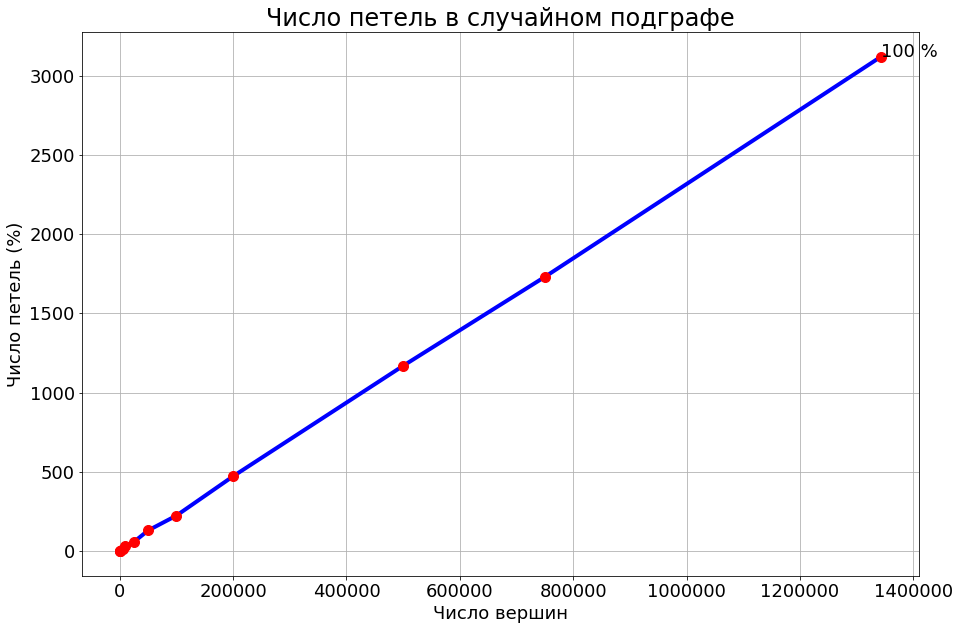

In [11]:
proportion = 1
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
count_direction_K2 = count_metric(G, get_loop, 'Число петель', proportion, sizes_subgraph)

plt.figure(figsize=(15, 10))
custom_plot(
    sizes_subgraph, count_direction_K2,
    'Число петель в случайном подграфе',
    'Число петель (%)',
    str(proportion * 100) + ' %'
)

del count_direction_K2
del sizes_subgraph

Действительно, как ни пародоксально, но некоторые работы ссылаются сами на себя. Связано, скорее всего, это с двумя вещами:

* Ошибка в построении датасета (скорее всего исключено)
* Как было выяснено в предыдущем пункте, статьи, являющиеся результатом работы на конференции, ссылаются сами на себя

Для нас будет главной целью показать, что не только статьи по результатам работы на конференциях ссылаются сами на себя (как это было выяснено выше). Это также делают отдельные группы и авторы.

In [12]:
proportion = 1
loops = count_metric(G, get_loop, 'Число петель', proportion, [len(G.nodes)], True)

In [ ]:
temp_loops = []
for doc in loops[0]:
    temp_loops.append(doc)

temp_loops = list(set(temp_loops))

authors = []
for doc in temp_loops:
    authors += docs[doc][ArxivTags.Authors]
    
del temp_loops

authors = Counter(authors)
count_papers = []
for key in authors:
    count_papers.append(authors[key])    

In [ ]:
count_papers = []
for author in authors:
    count_papers.append(authors[author])

Давайте выведем все статьи с петлями:

In [200]:
loops

[['1502.01582',
  '1511.02690',
  '0907.2236',
  '1704.01607',
  'astro-ph/0005440',
  '1007.3336',
  '1312.2255',
  '1204.6259',
  'cond-mat/9912130',
  '1504.06423',
  'solv-int/9704004',
  '1607.07942',
  '1202.4050',
  '0809.2304',
  '1501.00049',
  'astro-ph/0209082',
  'gr-qc/0307096',
  '0812.4209',
  '1010.3912',
  '1605.09675',
  '0708.1229',
  '1510.00693',
  'gr-qc/9905104',
  'gr-qc/0507067',
  '0806.1146',
  '1207.1333',
  '0807.2158',
  'hep-th/0103097',
  '1305.4699',
  '1612.01091',
  'math/0008123',
  '1704.06498',
  '1002.3312',
  '1609.09149',
  '1609.00303',
  '1701.04840',
  '1010.4321',
  'hep-th/0610278',
  '1710.09756',
  '0808.0047',
  'math/9903021',
  '1107.4038',
  '1201.3328',
  'quant-ph/0201148',
  '1308.0544',
  'physics/0407137',
  '1310.2213',
  'quant-ph/0211168',
  '1012.5690',
  'math/0103015',
  '1507.08834',
  '1604.05396',
  '1403.7714',
  '1306.6818',
  '1506.08479',
  '1409.6952',
  '1101.0226',
  '1204.0350',
  '1105.0632',
  '1309.0906',
  '0

Возьмём в рассмотрение несколько статей:

* [1704.01607](https://arxiv.org/pdf/1704.01607.pdf) -- нет ссылки самой на себя
* [0907.2236v3](https://arxiv.org/pdf/0907.2236.pdf) -- в тексте указана ссылка на вторую версию
* [1305.4699](https://arxiv.org/pdf/1305.4699.pdf) -- ошибка в указании ссылки. [Вот](https://arxiv.org/abs/1402.7356) корректная ссылка
* [1612.01091v2](https://arxiv.org/pdf/1612.01091.pdf) -- в тексте указана ссылка на первую версию
* [0901.3150v4](https://arxiv.org/pdf/0901.3150.pdf) -- в тексте указна ссылка на первую версию

И так далее. 10 из 10 рассмотренных статей не ссылались непосредственно на себя. Таким образом, петли являются либо ошибками, либо ссылками на более ранние версии статей.

In [ ]:
del loops

### Трёхвершинные паттерны

Давайте рассмотрим все возможные конфигурации треугольников для орграфов. Для начала, выделим все типы треугольников без обратных связей (их 2). Рассмотрим первый из них:

![stagnation.png](stagnation.png),

Назовём такой треугольник ($F_3$). Выше мы рассматривали подобные паттерны меньшей размерности. Другим видом трёхвершинных паттернов, является:

![generalization.png](generalization.png)

Его наречём **обобщение ($G_3$ от англ. generelization)**. Обобщением назовём данный паттерн по той причине, что у нас есть 1 вершина, на которую ссылаются 2 других. Таким образом, можно сделать предположение, о том, что автор, сделав ссылку на более раннюю работу, произвёл обобщение уже существующих выводов. Но не стоит забывать, что у данного графа существуют ссылки в будущее, как мы это показали в предыдущих разделах. Поэтому, для уточнения исследований, стоит отдельно анализировать ссылки в будущее.

Подобным же образом можно рассмотреть и все трёхвершинники, которые имеют обратные связи.

# Распределение степеней вершин графа

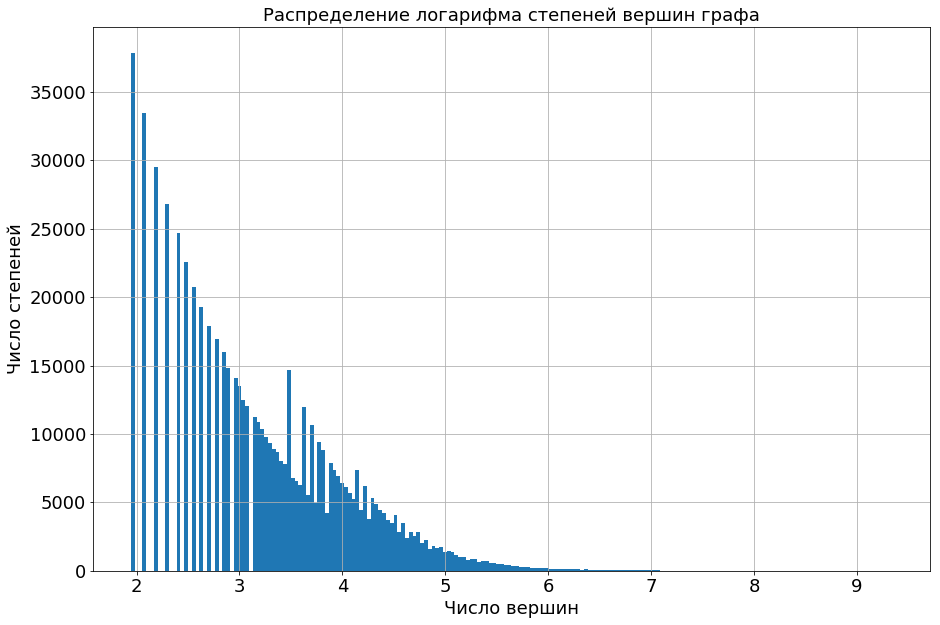

In [17]:
degs = []
for item in G.degree:
    degs.append(item[1])

plt.figure(figsize=(15,10))
plt.title('Распределение логарифма степеней вершин графа', fontsize=18)
plt.xlabel('Число вершин', fontsize=18)
plt.ylabel('Число степеней', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(np.log1p(np.array(degs)[np.array(degs) > 5]), bins=200)
plt.grid(True);

На графике выше представлено распределение логарифма числа степеней вершин. Мы видим несколько наложенных друг на друга убывающих распределения. Гипотеза, которую можно выдвинуть в данном случае, связана с тем, что для различных тем распределения оказываются различными. В связи с этим, на гистограмме проявляются такого рода особенности.

In [ ]:
degs = []
for item in G.degree:
    degs.append(item[1])

plt.figure(figsize=(15,10))
plt.title('Распределение логарифма степеней вершин графа', fontsize=18)
plt.xlabel('Число вершин', fontsize=18)
plt.ylabel('Число степеней', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(np.log1p(np.array(degs)[np.array(degs) > 5]), bins=200)
plt.grid(True);

In [37]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
m_cv = 5
vertexes = list(G.nodes)
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = list(np.array(vertexes)[perm])[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

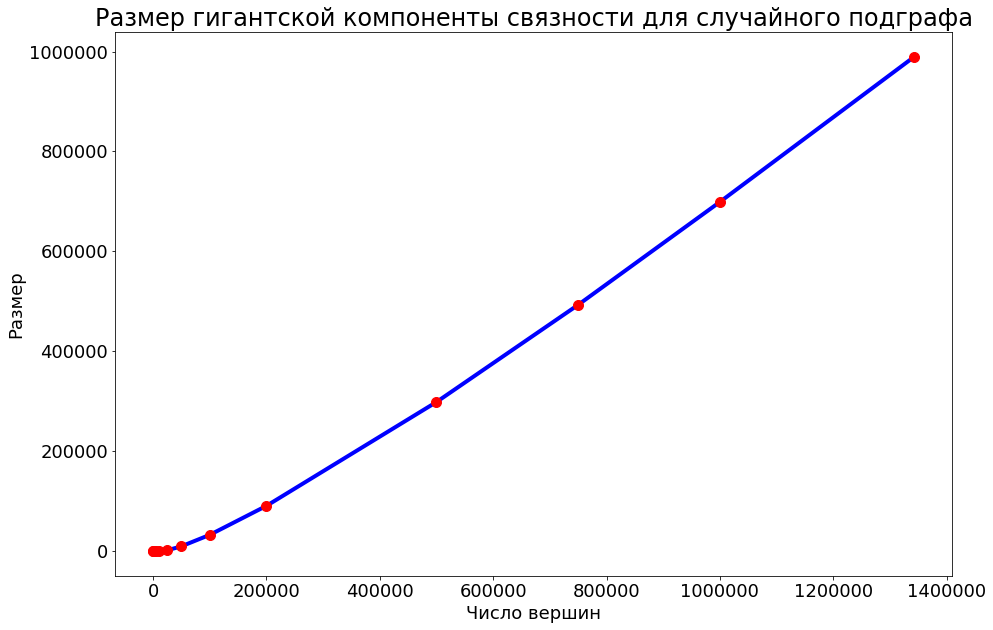

In [38]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

Как и для большинства характеристик стационарного графа, видим линейную зависимость.

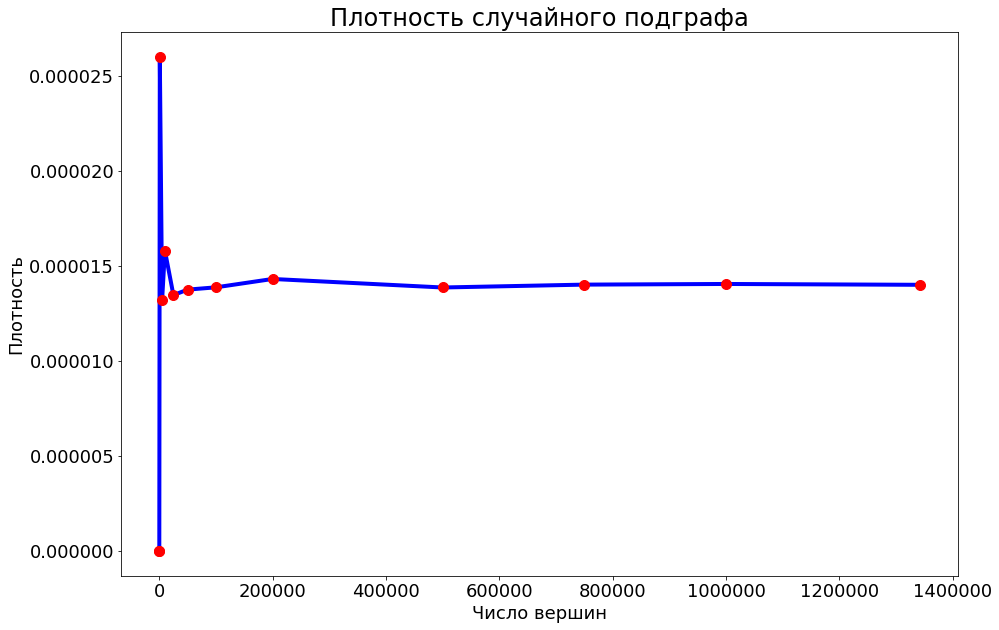

In [39]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

Плотность графа не зависит от подмножества вершин. Это косвенно может означать, что любые тематические подграфы имеют одинаковую плотность.

Отметим, что после того, как мы убрали "мелкие" кластеры, плотность графа выросла на 2 порядка. График, демонстрирующий этот факт не приведён здесь.

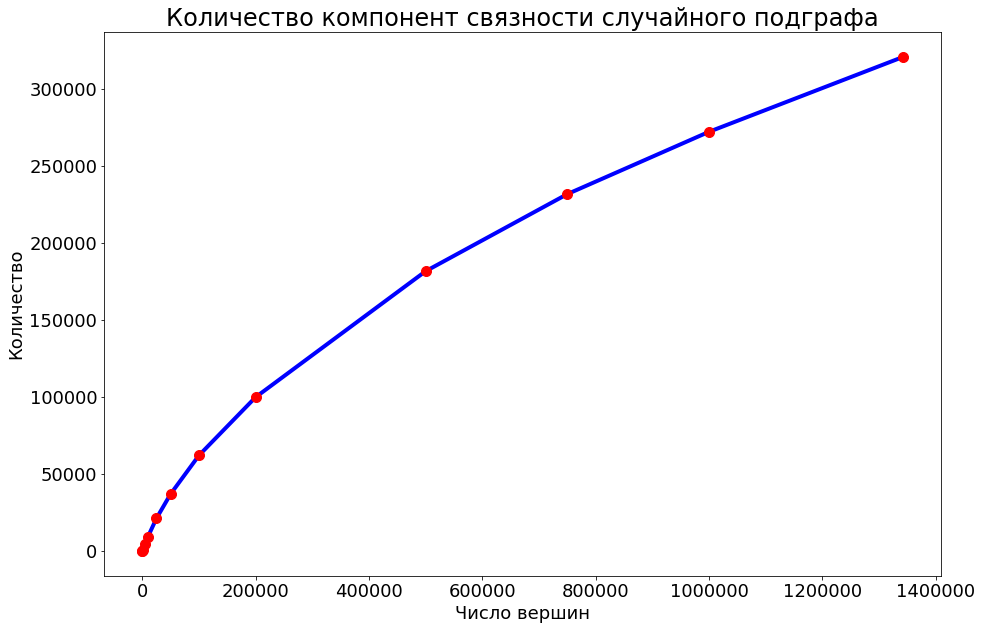

In [40]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

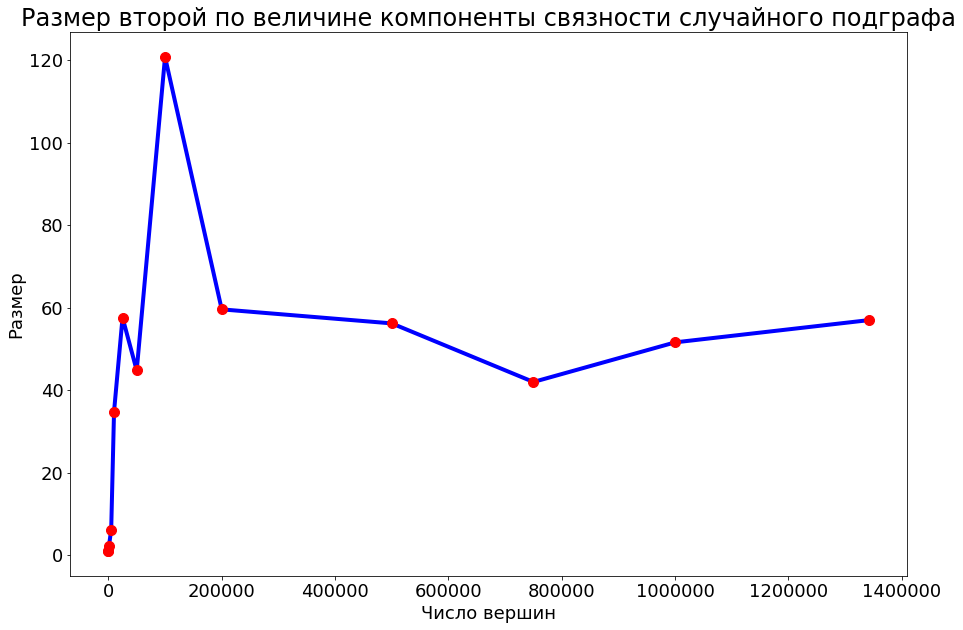

In [41]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

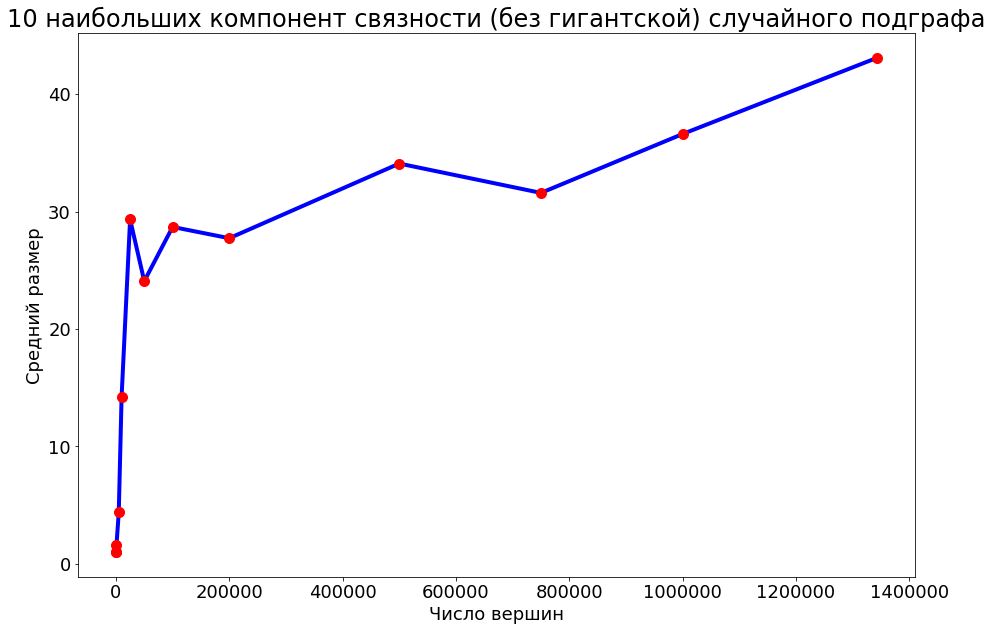

In [42]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

In [14]:
cc = sorted([c for c in list(nx.connected_components(G))], key=lambda el: len(el))[::-1][1:]
flatten_cc = []
for c in cc:
    for x in c:
        flatten_cc.append(x)
v_for_deleted = set(flatten_cc)

for doc in docs:
    edges = []
    for v in docs[doc][ArxivTags.Edges]:
        if v not in v_for_deleted:
            edges.append(v)
    docs[doc][ArxivTags.Edges] = edges
    
for doc in v_for_deleted:
    del docs[doc]
    
del cc
del flatten_cc
del v_for_deleted

In [19]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

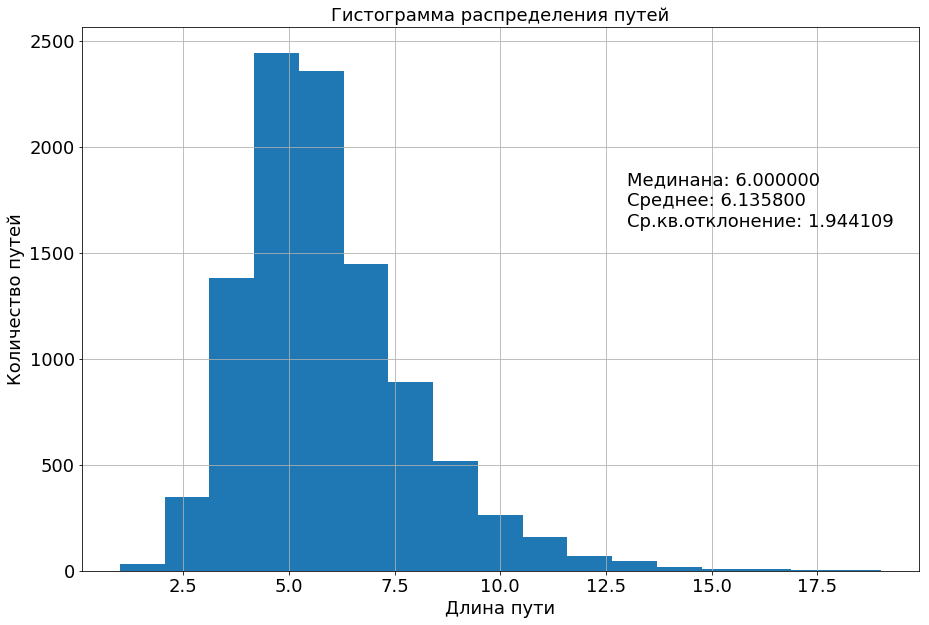

In [20]:
vertexes = list(G.nodes)
n_cv = 10000
len_paths = []
np.random.seed(42)
for i in tqdm_notebook(range(n_cv)):
    a = np.random.randint(len(vertexes))
    b = np.random.randint(len(vertexes))
    len_paths.append(nx.shortest_path_length(G, source=vertexes[a], target=vertexes[b]))
del vertexes

plt.figure(figsize=(15, 10))
plt.hist(len_paths, bins=17)
plt.grid(True)
plt.ylabel('Количество путей', fontsize=18)
plt.xlabel('Длина пути', fontsize=18)
plt.title('Гистограмма распределения путей', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.text(13, 1820, 'Мединана: %f' % np.median(len_paths), fontsize=18)
plt.text(13, 1720, 'Среднее: %f' % np.mean(len_paths), fontsize=18);
plt.text(13, 1620, 'Ср.кв.отклонение: %f' % np.sqrt(np.var(len_paths)), fontsize=18);

Гистограмму напрямую демонстрирует, что для данного графа гипотеза малого мира выполняется.

# Анализ графа по времени

Теперь перейдём к рассмотрению графа относительно времени

In [64]:
del docs
del G

In [65]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:24<00:00,  1.15s/it]


In [83]:
G = nx.Graph()
for doc in tqdm_notebook(docs):
    v = docs[doc]
    G.add_node(v[ArxivTags.Id])
    for v1 in v[ArxivTags.Edges]:
        if v1 in ['1709.00106', '0806.4730', '1710.01852', '1711.09052', '1610.02738', '1608.08468', '1709.07096']:
            continue
        G.add_edge(doc, v1)
        G.add_edge(v1, doc)

In [84]:
remove_noise_tags(docs)

In [86]:
docs_by_years = {}
for year in range(1991, 2018):
    docs_by_years[year] = []

for doc in docs:
    docs_by_years[docs[doc][ArxivTags.Year]].append(doc)

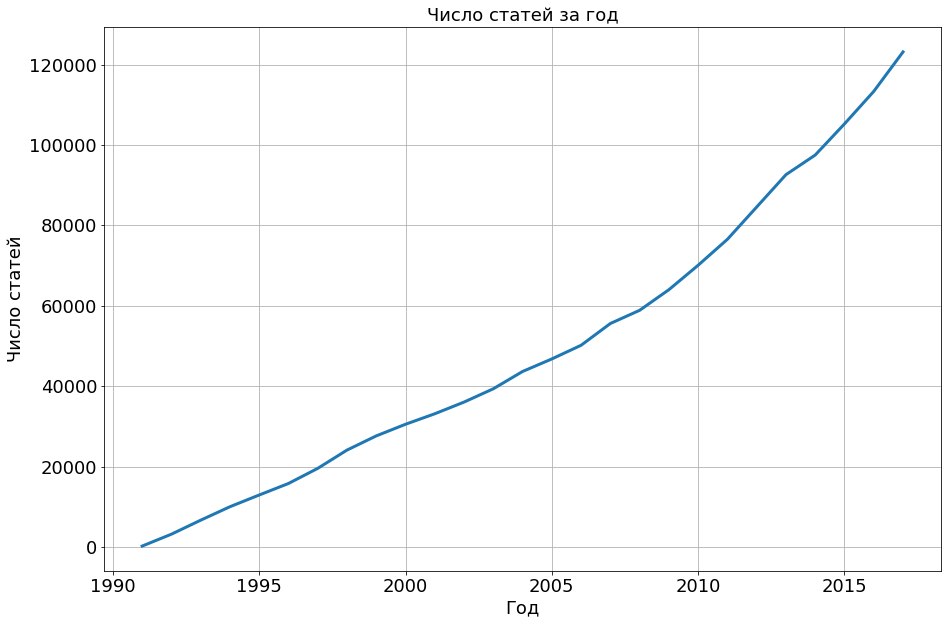

In [87]:
counts_papers = [len(docs_by_years[y]) for y in docs_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts_papers, linewidth=3)
plt.grid(True)
plt.ylabel('Число статей', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Число статей за год', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

Со временем, число статей увеличивается. Это может говорить о нескольких вещах: сообщество людей увеличивается и порождает большое количество работ в связи с этим. Каждый, отдельно взятый человек порождает всё б'ольшое количество статей. Здесь, под сообществом понимается группа людей, каждый из которых хотя бы раз в год публикует не менее 1 статьи. Взглянем на распределение авторов по годам:

In [88]:
authors_by_years = {}
for year in range(1991, 2018):
    authors_by_years[year] = []

for doc in docs:
    authors_by_years[docs[doc][ArxivTags.Year]] += docs[doc][ArxivTags.Authors]

for year in authors_by_years:
    authors_by_years[year] =  list(set(authors_by_years[year]))

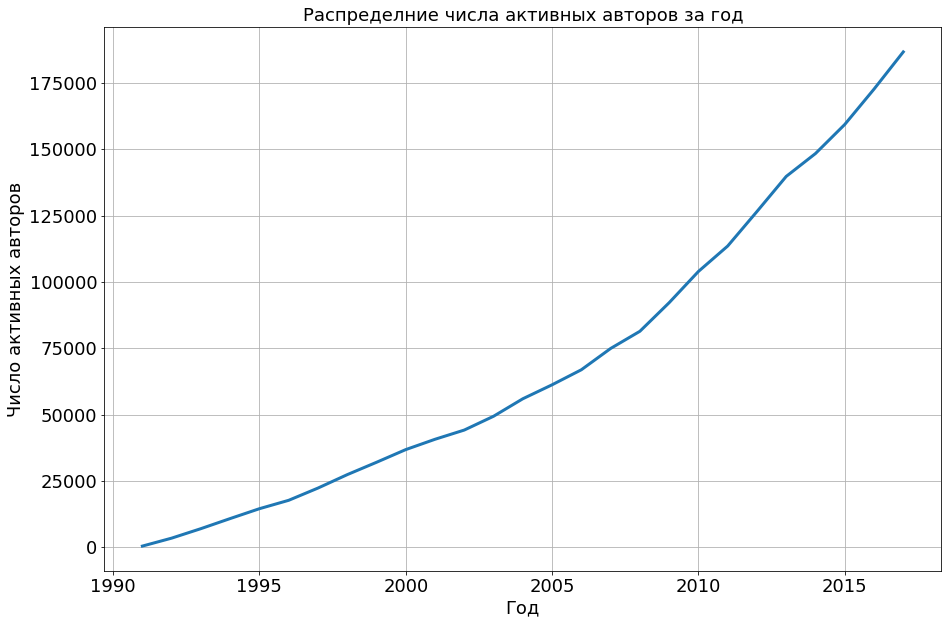

In [89]:
counts_authors = [len(authors_by_years[y]) for y in authors_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts_authors, linewidth=3)
plt.grid(True)
plt.ylabel('Число активных авторов', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Распределние числа активных авторов за год', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

Число активных авторов растёт. Причём происходит это нелинейно. Значит, всё больше и больше людей втягиваются в написание статей. Как следствие, в исследовательские проекты. Из этого графика также следует, что даже если люди прекращают писать статьи, число вновь ставших активными авторов плюс новичков, оказывается больше.

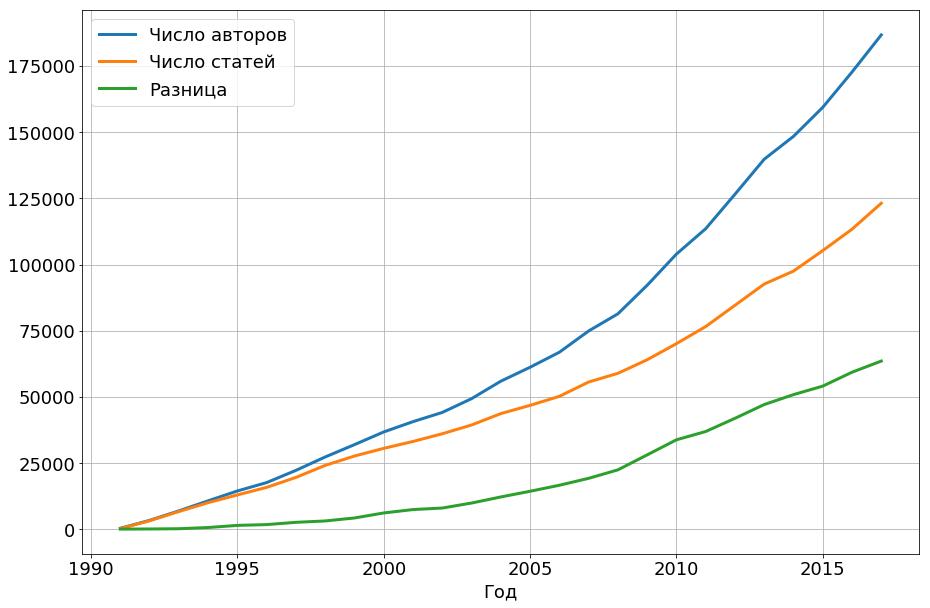

In [90]:
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts_authors, linewidth=3)
plt.plot(years, counts_papers, linewidth=3)
plt.plot(years, np.array(counts_authors) - np.array(counts_papers), linewidth=3)
plt.grid(True)
plt.ylabel('', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['Число авторов', 'Число статей', 'Разница'], fontsize=18)
plt.grid(True)

Но есть и печальная тенденция (или не очень). Число авторов растёт быстрее, чем число статей. А значит, на одно статью приходится в среднем больше людей, чем ранее. Как правило, это говорит о том, что при написании статей, есть несколько ведущих людей, которые выполняют большую часть работы (здесь должен работать хорошо закон 20-80), а есть, так сказать, нахлебники. 

Но давайте, всё-такие надеяться на лучшее. Быть может, указанную разницу формируют конференции, которых в последнее время, очевидно, становится больше. Авторы публикуют доклады на конференциях в соавторстве с кем-нибудь и за счёт этого удельная доля авторов повышается.

Посмотрим теперь на медиану, среднее и дисперсию этих характеристик.

In [91]:
authors_by_years = {}
for year in range(1991, 2018):
    authors_by_years[year] = []

for doc in docs:
    authors_by_years[docs[doc][ArxivTags.Year]] += docs[doc][ArxivTags.Authors]

for year in authors_by_years:
    authors_by_years[year] = [item[1] for item in Counter(authors_by_years[year]).items()]

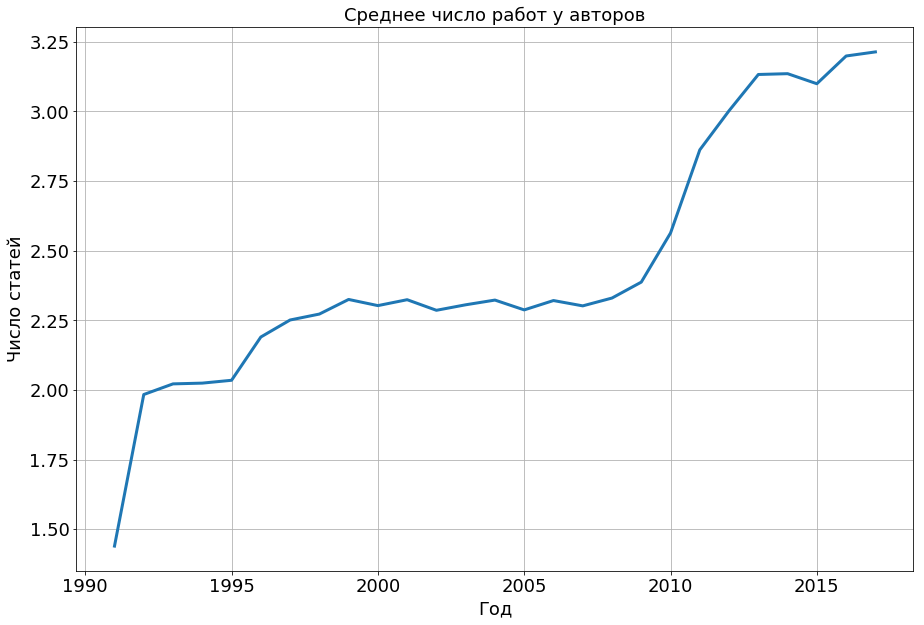

In [92]:
counts = [np.mean(authors_by_years[y]) for y in authors_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts, linewidth=3)
plt.ylabel('Число статей', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Среднее число работ у авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

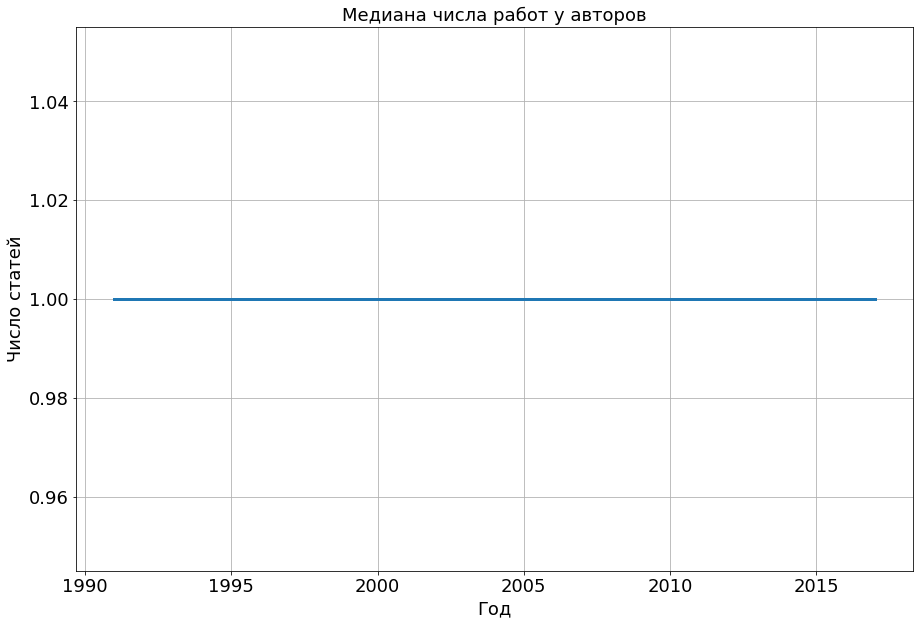

In [93]:
counts = [np.median(authors_by_years[y]) for y in authors_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts, linewidth=3)
plt.ylabel('Число статей', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Медиана числа работ у авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

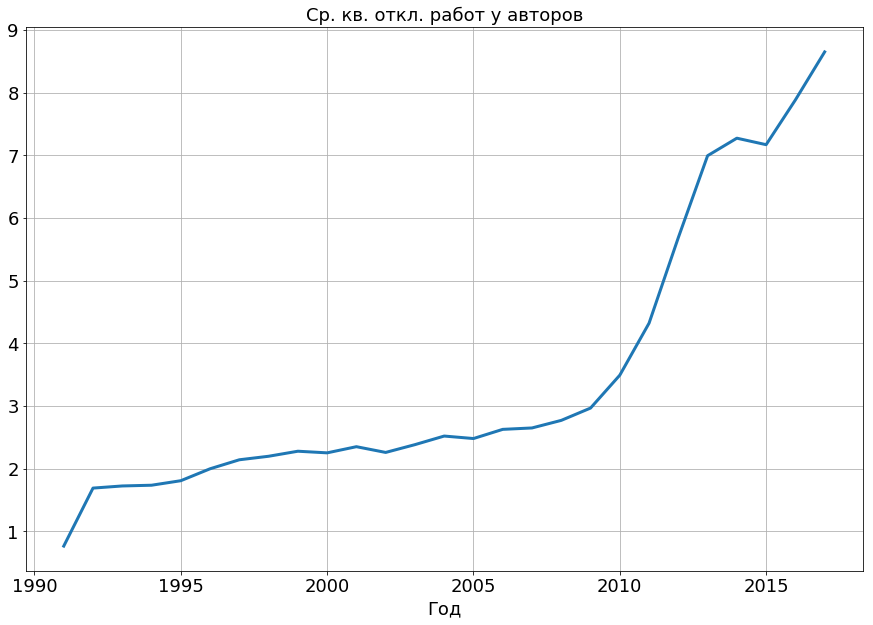

In [94]:
counts = [np.sqrt(np.var(authors_by_years[y])) for y in authors_by_years]
years = [y for y in docs_by_years]
plt.figure(figsize=(15, 10))
plt.plot(years, counts, linewidth=3)
plt.ylabel('', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.title('Ср. кв. откл. работ у авторов', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)

Как видим, начиная с 2009 года, произошёло изменение в характере распределния числа статей. Сообщество Arixv, вероятно начало делиться на части: люди, которые много пишут статьи и люди, которые пишут их совершенно немного. Со временем эта тенденция усиливается.

Что касается среднего числа работ, то видим, что до 2013 года было резкое увеличение удельной доли работ у авторов. До текущего момента оно опять стабилизировалось. Вероятно, это связано со вспышкой интереса к какой-либо области знаний. Возможно, речь идёт о машинном обучении, в частности о глубоком обучении.

### Гигантская компонента связности

Посмотрим, как росла гиганская компонента связности, при добавлении вершин в хронологическом порядке.

In [95]:
sorted_by_year_docs = []

for doc in docs:
    splitted = doc.split('/')
    if len(splitted) == 2:
        splitted = splitted[1]
        if int(splitted[:2]) > 90:
            year = 1900 + int(splitted[:2])       
        else:
            year = 2000 + int(splitted[:2])       
        year_month = year * 100 + int(splitted[2:4])
        year_month_num = year_month * 10000 + int(splitted[4:])
        year_month_num_r = year_month_num * 1000 + np.random.randint(100)
        sorted_by_year_docs.append((doc, year_month_num_r))
    else:
        splitted = splitted[0].split('.')
        a = splitted[0]
        b = splitted[1]
        year = 2000 + int(a[:2])       
        year_month = year * 100 + int(a[2:4])
        year_month_num = year_month * 100000 + int(b)
        sorted_by_year_docs.append((doc, year_month_num * 100))

In [96]:
max_comp_sizes = []
mean_10_max_comp_size_without_first = []
second_comp_size = []
count_comps = []
density_subgraph = []
sizes_subgraph = [5, 100, 1000, 5000, 10000, 25000, 50000, 100000, 200000, 500000, 750000, len(G.nodes)]
vertexes = list([item[0] for item in sorted_by_year_docs])
m_cv = 5
for n in tqdm_notebook(sizes_subgraph):
    second_comp_size_ = []
    mean_10_max_comp_size_without_first_ = []
    for m in range(m_cv):
        perm = np.random.permutation(len(G.nodes))
        random_vertex = vertexes[:n]
        subgraph = G.subgraph(random_vertex)
        lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
        second_comp_size_.append(lens[1])
        mean_10_max_comp_size_without_first_.append(np.mean(lens[1:11]))
    second_comp_size.append(np.mean(second_comp_size_))
    mean_10_max_comp_size_without_first.append(np.mean(mean_10_max_comp_size_without_first_))
    
    lens = sorted([len(c) for c in list(nx.connected_components(subgraph))])[::-1]
    max_comp_sizes.append(lens[0])
    count_comps.append(len(lens))
    density_subgraph.append((2 * len(subgraph.edges)) / (len(subgraph.nodes) * (len(subgraph.nodes) - 1)))
del subgraph
del vertexes

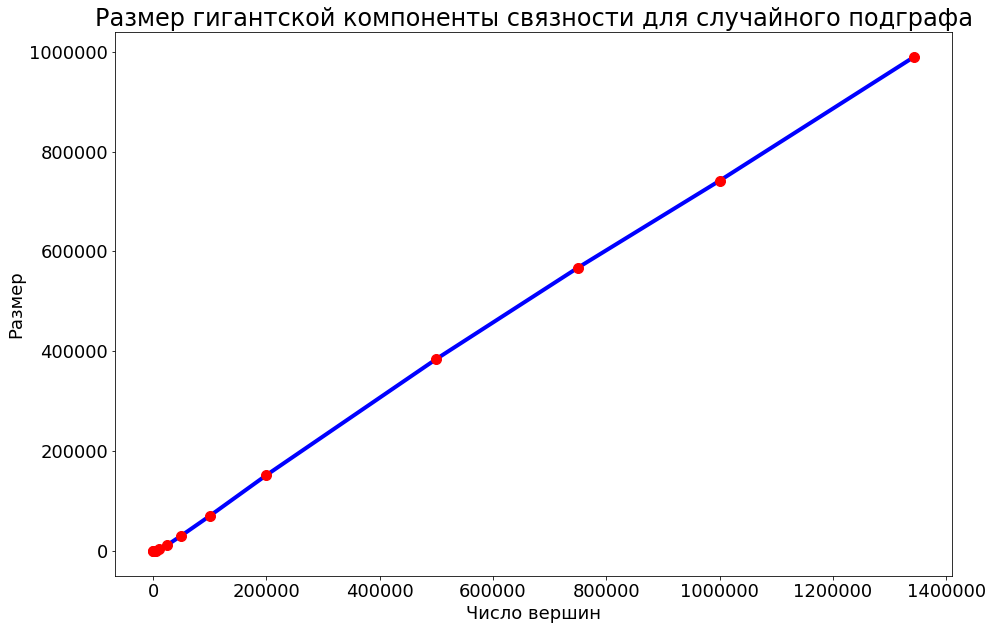

In [33]:
custom_plot(
    sizes_subgraph, max_comp_sizes,
    'Размер гигантской компоненты связности для случайного подграфа',
    'Размер'
)

Ничего неожиданного. Линейный рост от числа вершин.

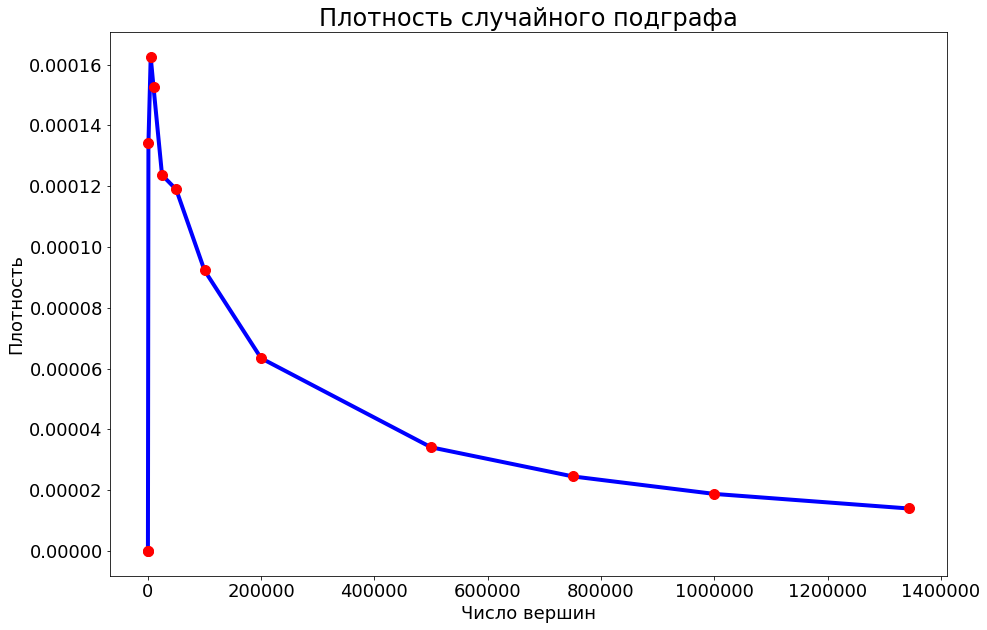

In [34]:
custom_plot(
    sizes_subgraph, density_subgraph,
    'Плотность случайного подграфа',
    'Плотность'
)

А вот с плотностью интересно. Получается, что плотность уменьшается. Это означает, что при растущем числе рёбер, число вершин растёт медленнее. Т.е. среднее число рёбер не меняется. Если мы вспомним, что в случае стационарного графа, плотность была константной, то характер роста плотности значительно отличается.

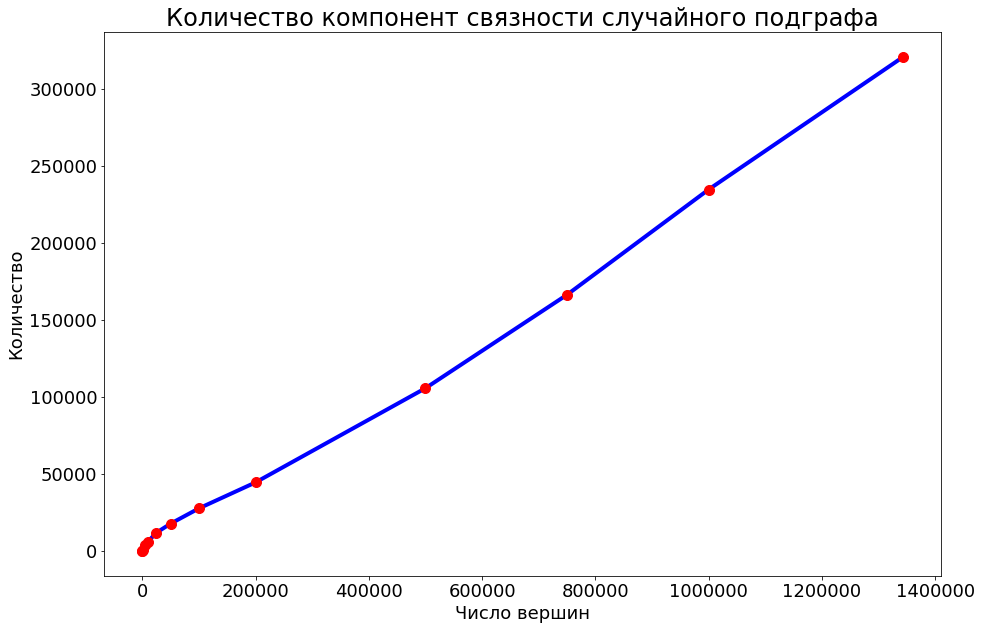

In [35]:
custom_plot(
    sizes_subgraph, count_comps,
    'Количество компонент связности случайного подграфа',
    'Количество'
)

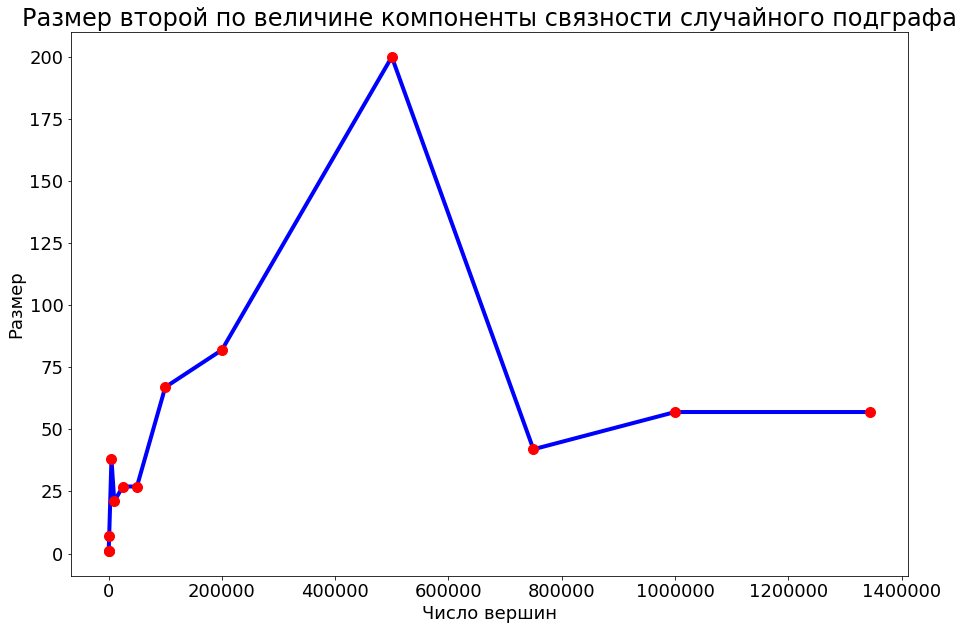

In [36]:
custom_plot(
    sizes_subgraph, second_comp_size,
    'Размер второй по величине компоненты связности случайного подграфа',
    'Размер'
)

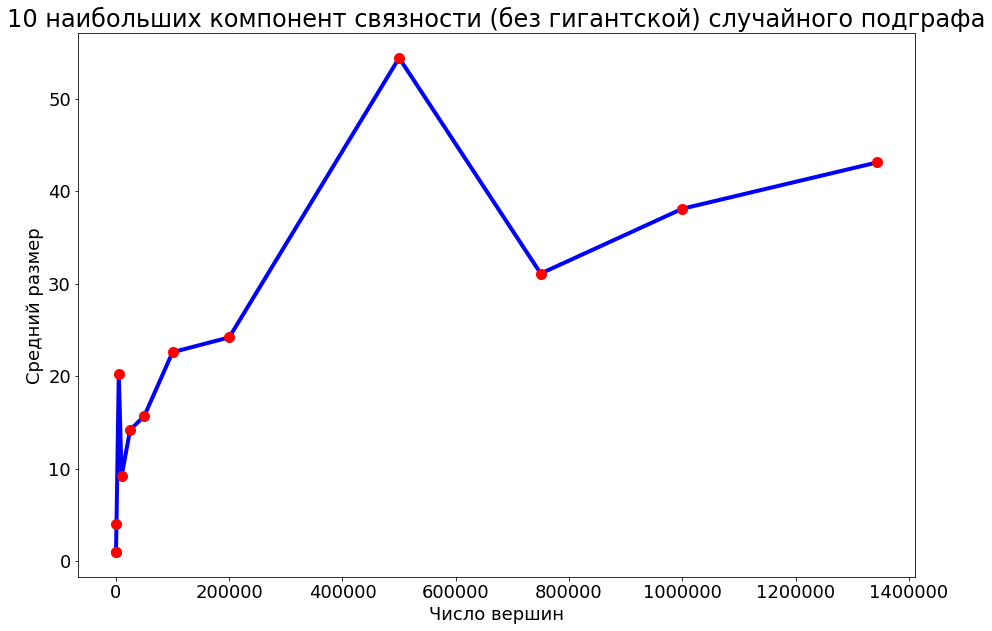

In [37]:
custom_plot(
    sizes_subgraph, mean_10_max_comp_size_without_first,
    '10 наибольших компонент связности (без гигантской) случайного подграфа',
    'Средний размер'
)

# Заключение

Мы говорили о графе. Но я так и не привёл ни одного из графов. Поэтому я решил, что нужно что-нибудь такое визуализировать. 

По картинкам этим выводы сделать сложно какие-то. Не особо они иллюстративные. Зато в моей работе про графы теперь есть картинки с графами.

In [70]:
del docs

In [71]:
docs = load_arxiv("paperscape-data-master/")

tags = set([])
for doc in docs:
    tags = tags.union(docs[doc][ArxivTags.Tags])
    
general_tags = set([])
for doc in docs:
    general_tags = general_tags.union(docs[doc][ArxivTags.GeneralTags])

100%|██████████| 27/27 [00:20<00:00,  1.22s/it]


In [72]:
for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.GeneralTags]:
        if tag in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.GeneralTags].add(tag.split('.')[0])
    for tag in old_tags:
        docs[doc][ArxivTags.GeneralTags].remove(tag)

for doc in docs:
    new_tags = set([])
    old_tags = set([])
    for tag in docs[doc][ArxivTags.Tags]:
        if tag.split('.')[0] in new_depr:
            old_tags.add(tag)
            new_tags.add(new_depr[tag])
    for tag in new_tags:
        docs[doc][ArxivTags.Tags].add(tag)
    for tag in old_tags:
        docs[doc][ArxivTags.Tags].remove(tag)

In [75]:
theme_g = nx.Graph()
for doc in tqdm_notebook(docs):
    tags0 = docs[doc][ArxivTags.GeneralTags]
    tags1 = []
    for v in docs[doc][ArxivTags.Edges]:
        tags1 += docs[v][ArxivTags.GeneralTags]
    for t0 in tags0:
        if t0 in ['eess', 'econ']:
            continue
        for t1 in tags1:
            if t1 in ['eess', 'econ']:
                continue
            if theme_g.has_edge(t0, t1):
                theme_g[t0][t1]['weight'] += 1
                theme_g[t1][t0]['weight'] += 1
            else:
                theme_g.add_edge(t0, t1, weight=1)
                theme_g.add_edge(t1, t0, weight=1)

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


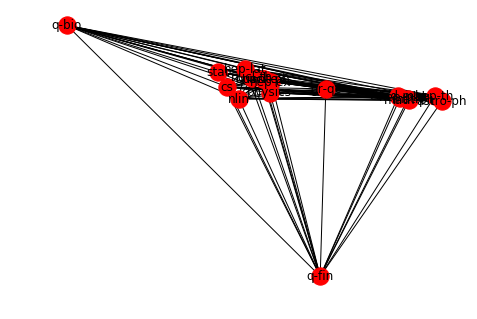

In [76]:
nx.draw(theme_g, with_labels=True)

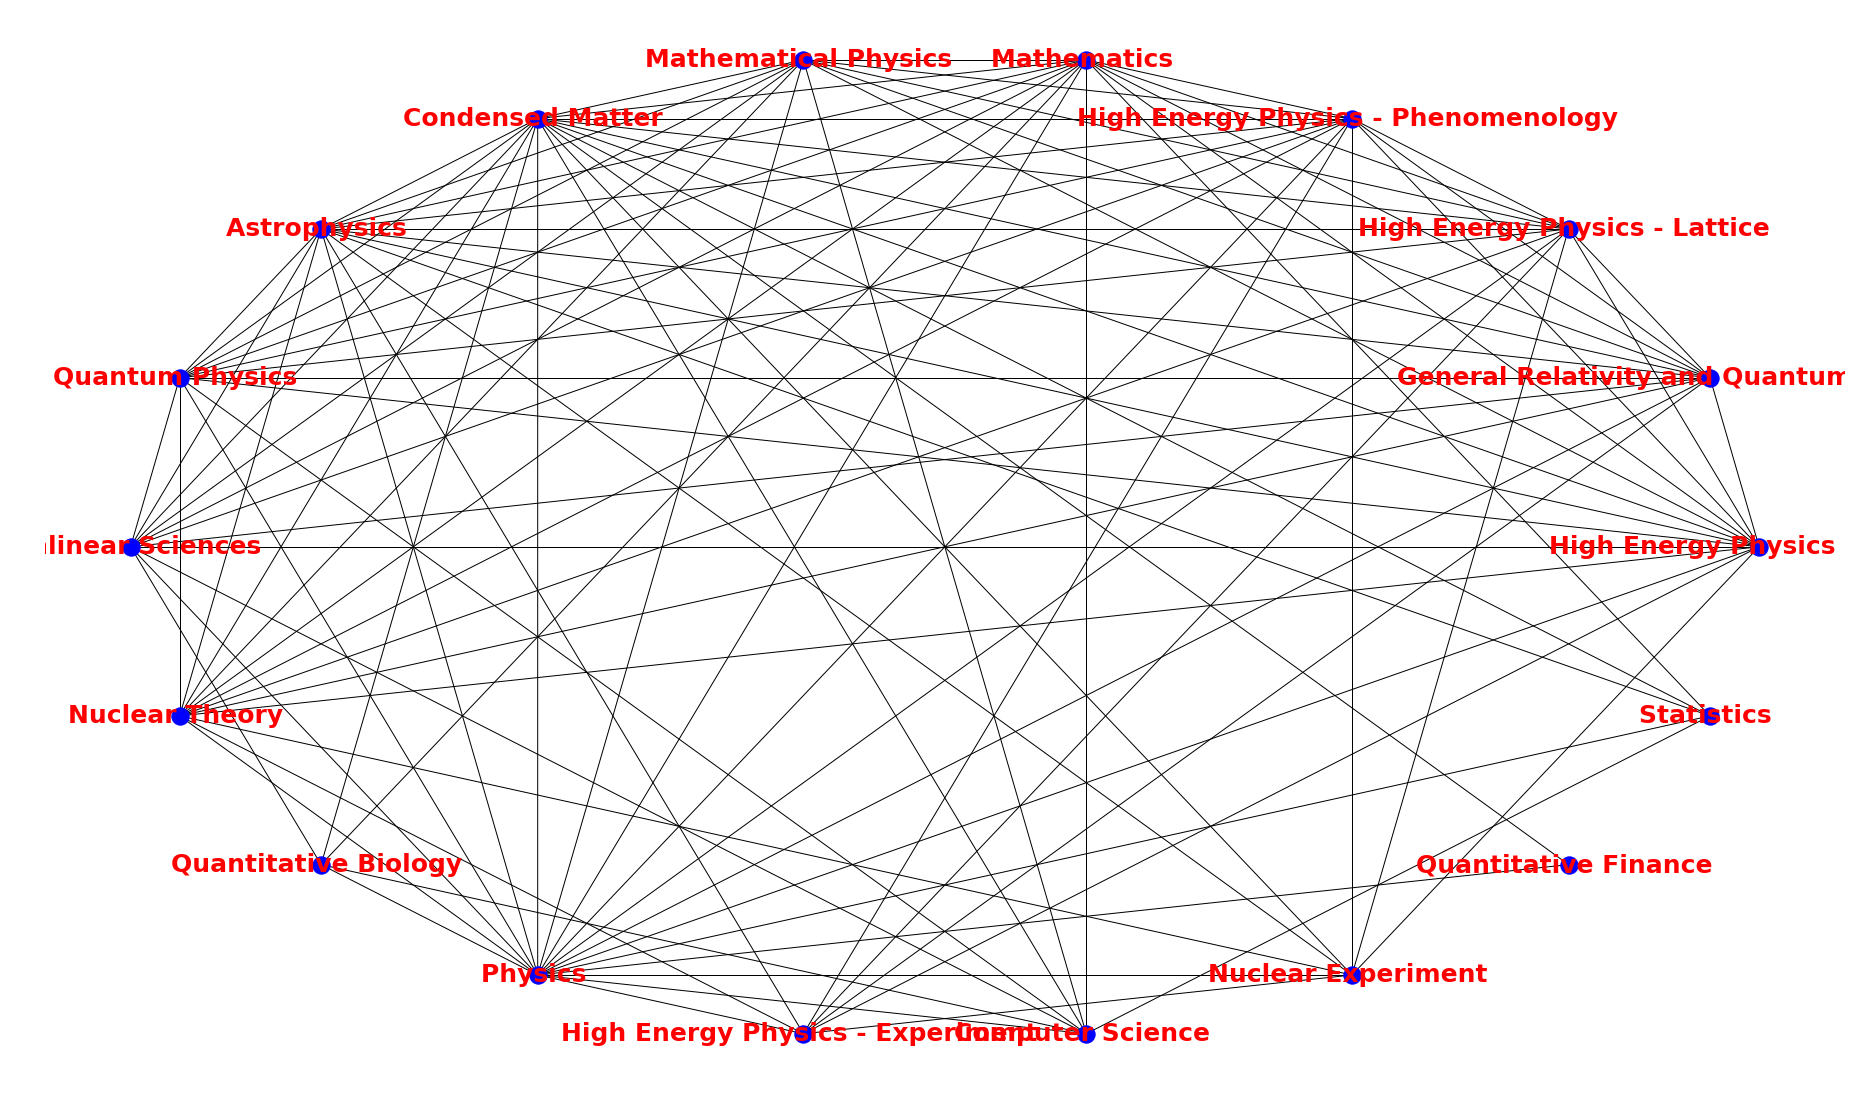

In [183]:
from copy import deepcopy
theme_g_new = deepcopy(theme_g)
theme_g_new = nx.relabel_nodes(theme_g_new, actuals)
t = 1000
for n0 in theme_g_new.nodes:
    for n1 in theme_g_new.nodes:
        if n1 in theme_g_new[n0] and theme_g_new[n0][n1]['weight'] < 10000:
            theme_g_new.remove_edge(n0, n1)
            
plt.figure(figsize=(25,15))
theme_g_new.remove_nodes_from(list(nx.isolates(theme_g_new)))
nx.draw_shell(theme_g_new, with_labels=True, font_size=25, font_color='red', font_weight=1000, node_color='blue')

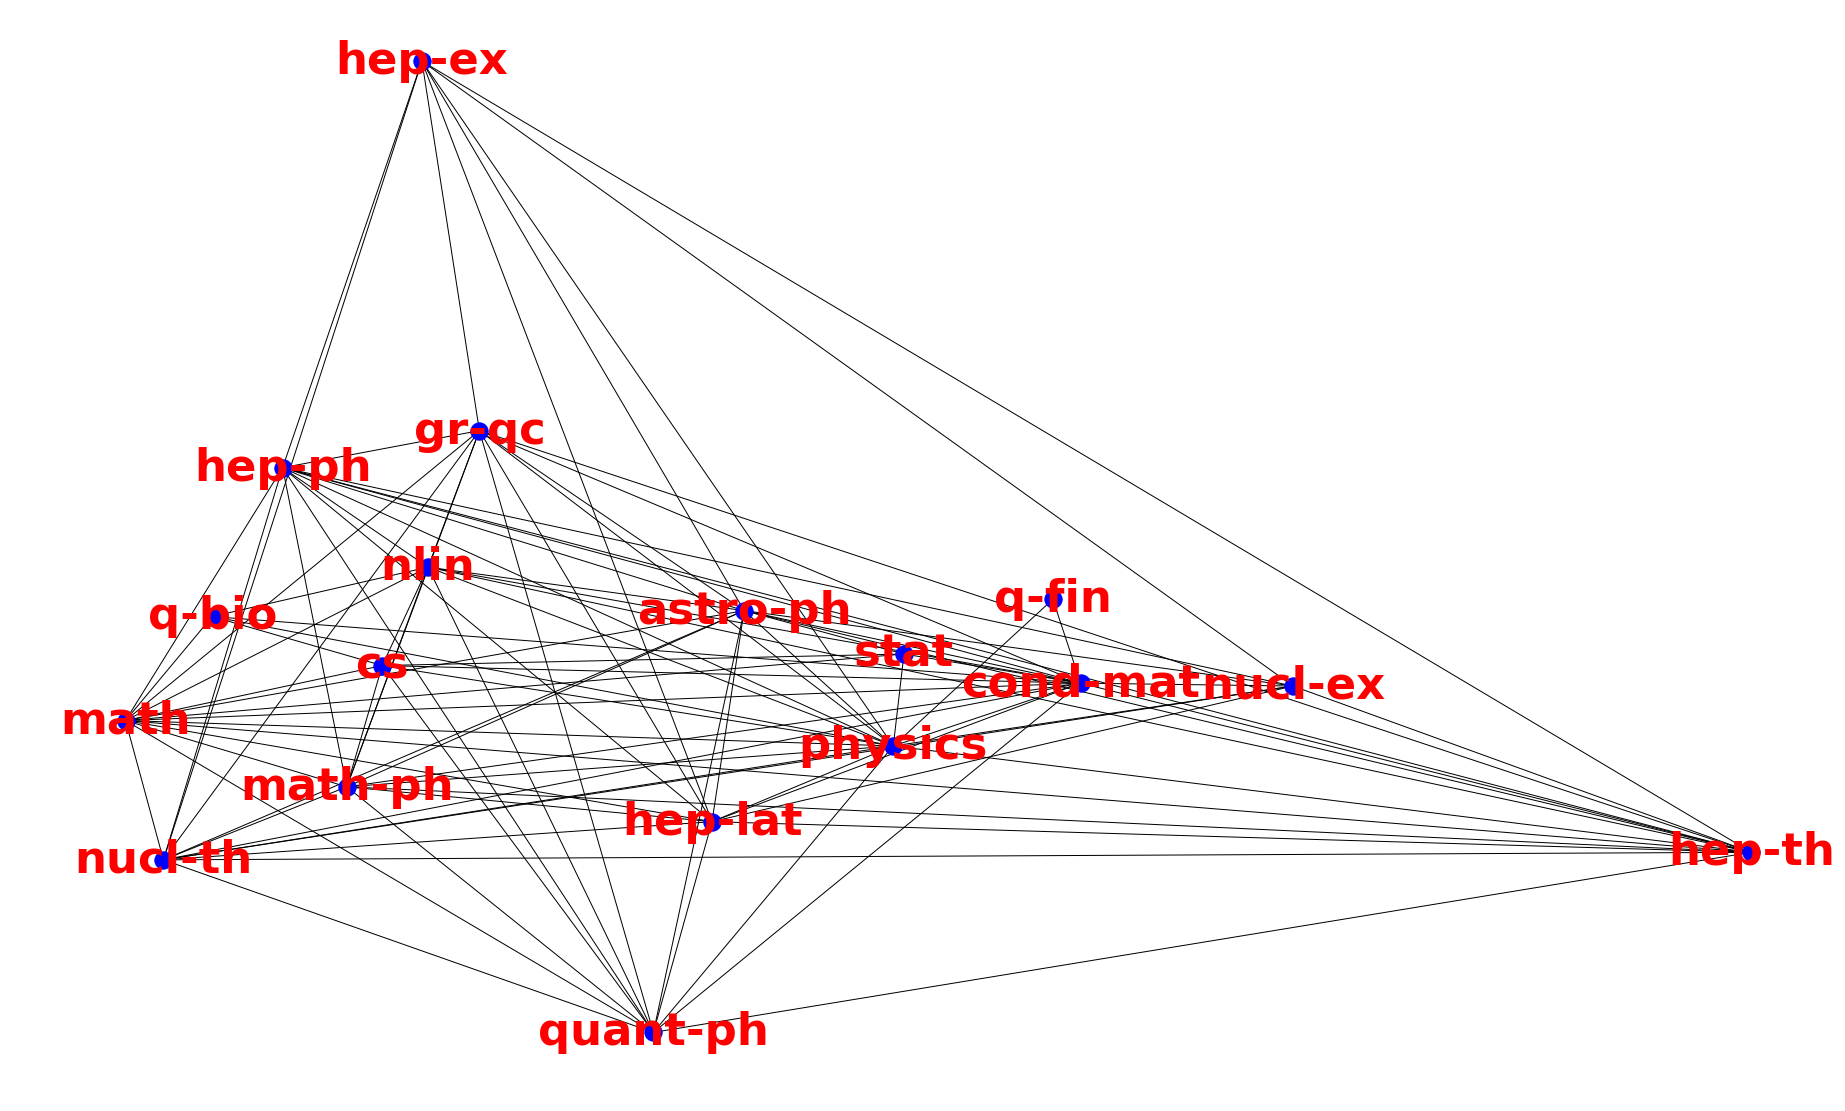

In [189]:
theme_g_new = nx.relabel_nodes(theme_g_new, {item[1]:item[0] for item in actuals.items()})

plt.figure(figsize=(25,15))
nx.draw_kamada_kawai(theme_g_new, with_labels=True, font_size=45, font_color='red', font_weight=1000, node_color='blue')